# Libraries

In [358]:
# general libraries
import numpy as np
import pandas as pd
import os
from itertools import combinations
from pathlib import Path
import joblib

# dataframes 
import pandas as pd
import pyspark as spark


# statistics
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

# data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# unsupervised learning
from sklearn.decomposition import PCA


# ml & ai
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics  import (
    mean_squared_error, 
    mean_absolute_error, 
    explained_variance_score, 
    median_absolute_error, 
    max_error, 
)

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import train_test_split


# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# interpretation
import shap
import lime
import lime.lime_tabular

# api &  deployment
import flask
from flask import Flask, request, jsonify



# Wizeline - ML Implementing Challenge

## Datasets

In [64]:
# load tabular data from csv file
data = pd.read_csv('data/training_data.csv')

# Define the directory path
directory = 'data/bronze'

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the file
data.to_csv(f'{directory}/data_bronze.csv', index=False)

In [65]:
# ver tipos de variables(independientes)
data.dtypes

feature_0     float64
feature_1     float64
feature_2     float64
feature_3     float64
feature_4     float64
feature_5     float64
feature_6     float64
feature_7     float64
feature_8     float64
feature_9     float64
feature_10    float64
feature_11    float64
feature_12    float64
feature_13    float64
feature_14    float64
feature_15    float64
feature_16    float64
feature_17    float64
feature_18    float64
feature_19    float64
target        float64
dtype: object

## EDA

* Statatistical Analysis
* Descriptive Analysis
* Correlation Techniques
* Variance and Covarianze
* Distrubution Analysis
* Statistical Tests
* Unsupervised Learning Methods
* Outlier Detection


### Statatistical Analysis

* Correlation Analysis:
* Boxplot Distribution Analysis: 
* VIF (Variance Inflation Factor) for Multicollinearity:

In [39]:

def analyze_dataframe(df, output_dir='data/eda/stats/', correlation_threshold=0.5, save_plots=True):
    """
    Performs comprehensive statistical and descriptive analysis on a numeric dataframe.
    Generates visualizations using matplotlib and seaborn.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing numeric data to analyze
    output_dir : str, default='analysis_plots/'
        Directory where to save generated plots
    correlation_threshold : float, default=0.7
        Threshold for highlighting high correlations
    save_plots : bool, default=True
        Whether to save plots to disk
        
    Returns:
    --------
    tuple
        (summary_stats, correlations, outliers_summary, feature_importance, normality_tests)
        All elements are pandas DataFrames containing the analysis results
    """

    if save_plots and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create copies to avoid modifying the original
    df_analysis = df.copy()
    
    # Initialize result DataFrames
    summary_stats = pd.DataFrame()
    correlations = pd.DataFrame()
    outliers_summary = pd.DataFrame()
    feature_importance = pd.DataFrame() 
    normality_tests = pd.DataFrame()
    
    # Basic statistics
    print("Calculating basic statistics...")
    summary_stats = df_analysis.describe().T
    summary_stats['missing'] = df_analysis.isnull().sum()
    summary_stats['missing_pct'] = df_analysis.isnull().mean() * 100
    summary_stats['unique_values'] = df_analysis.nunique()
    
    # Correlation analysis
    print("Performing correlation analysis...")
    correlations = df_analysis.corr()
    
    # Find high correlations (excluding self-correlations)
    high_corr_pairs = []
    for i in range(len(correlations.columns)):
        for j in range(i+1, len(correlations.columns)):
            if abs(correlations.iloc[i, j]) >= correlation_threshold:
                high_corr_pairs.append({
                    'feature1': correlations.columns[i],
                    'feature2': correlations.columns[j],
                    'correlation': correlations.iloc[i, j]
                })
    
    high_correlations = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)
    
    # Normality tests
    print("Testing for normality...")
    normality_results = []
    for column in df_analysis.columns:
        # Shapiro-Wilk test (best for smaller datasets)
        shapiro_test = stats.shapiro(df_analysis[column].dropna())
        
        # D'Agostino-Pearson test
        dagostino_test = stats.normaltest(df_analysis[column].dropna())
        
        normality_results.append({
            'feature': column,
            'shapiro_stat': shapiro_test[0],
            'shapiro_p_value': shapiro_test[1],
            'shapiro_normal': shapiro_test[1] > 0.05,
            'dagostino_stat': dagostino_test[0],
            'dagostino_p_value': dagostino_test[1],
            'dagostino_normal': dagostino_test[1] > 0.05
        })
    
    normality_tests = pd.DataFrame(normality_results)
    
    # Calculate VIF (Variance Inflation Factor) for multicollinearity
    X = df_analysis.values
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_analysis.columns
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    
    # Visualization Section
    print("Generating visualizations...")
    
    
    
    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlations, dtype=bool))
    sns.heatmap(correlations, mask=mask, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
    plt.title('Correlation Matrix')
    if save_plots:
        plt.savefig(f"{output_dir}correlation_heatmap.png", dpi=300, bbox_inches='tight')
    
    # Boxplots for outlier detection
    plt.figure(figsize=(15, 10))
    ax = sns.boxplot(data=df_analysis)
    plt.title('Boxplots for Outlier Detection')
    plt.xticks(rotation=90)
    if save_plots:
        plt.savefig(f"{output_dir}boxplots.png", dpi=300, bbox_inches='tight')
    
    # Scatter matrix for top correlated features
    if high_correlations.shape[0] > 0:
        top_correlated = set()
        for _, row in high_correlations.head(5).iterrows():
            top_correlated.add(row['feature1'])
            top_correlated.add(row['feature2'])
        
        top_correlated = list(top_correlated)[:5]  # Limit to 5 features
        
        if len(top_correlated) > 1:
            plt.figure(figsize=(15, 15))
            sns.pairplot(df_analysis[top_correlated])
            plt.suptitle('Pairplot of Top Correlated Features', y=1.02)
            if save_plots:
                plt.savefig(f"{output_dir}pairplot.png", dpi=300, bbox_inches='tight')
    
   

    # Calculate VIF (Variance Inflation Factor) for multicollinearity - excluding 'target' column
    if 'target' in df_analysis.columns:
        # Create a dataframe without the target column for VIF calculation
        df_features = df_analysis.drop('target', axis=1)
        X = df_features.values
        vif_features = df_features.columns
    else:
        # If no target column exists, use all columns
        X = df_analysis.values
        vif_features = df_analysis.columns

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["feature"] = vif_features
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

    # Multicollinearity (VIF) bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='VIF', y='feature', data=vif_data.sort_values('VIF', ascending=False))
    plt.title('Variance Inflation Factor (VIF) for Multicollinearity')
    plt.axvline(x=5, color='r', linestyle='--')  # Common threshold for VIF
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}vif_factors.png", dpi=300, bbox_inches='tight')

    print("Analysis complete!")
    
    # Display all figures if not explicitly saving
    if not save_plots:
        plt.show()
    
    return (summary_stats, correlations, outliers_summary, feature_importance, normality_tests)

Calculating basic statistics...
Performing correlation analysis...
Testing for normality...
Generating visualizations...


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


Analysis complete!


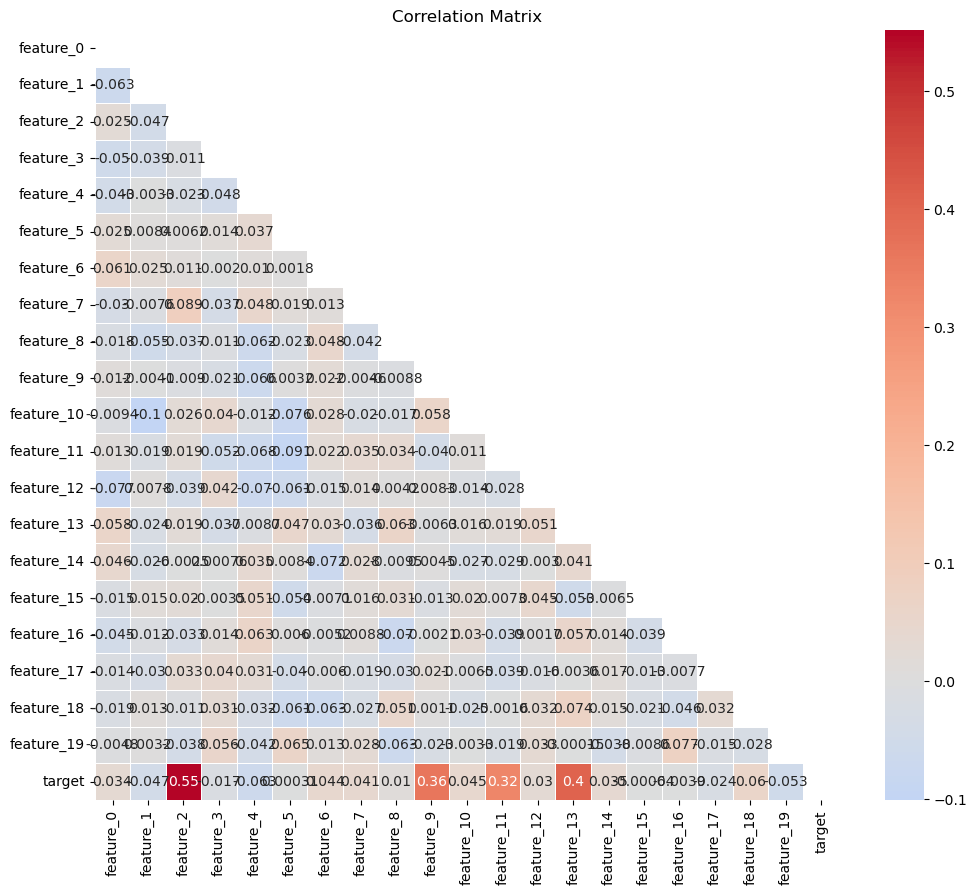

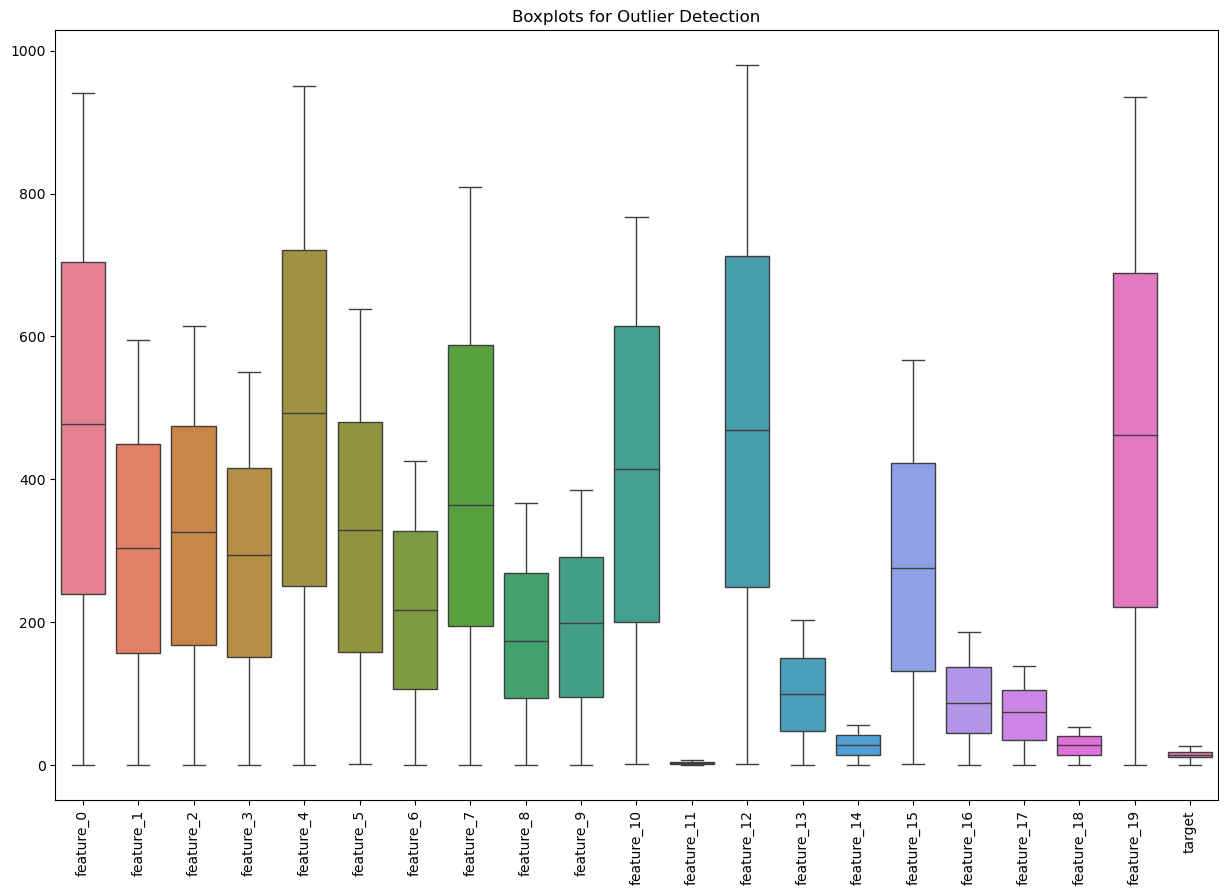

<Figure size 1500x1500 with 0 Axes>

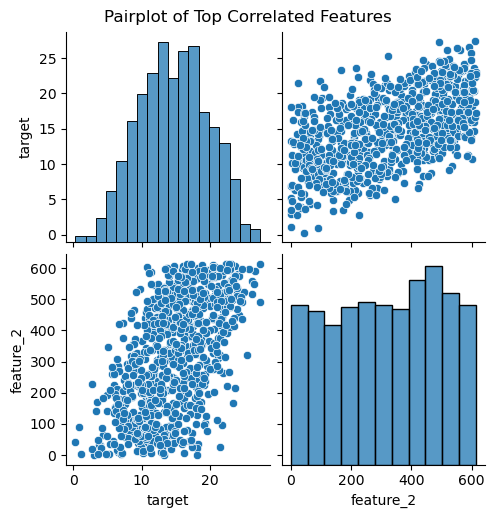

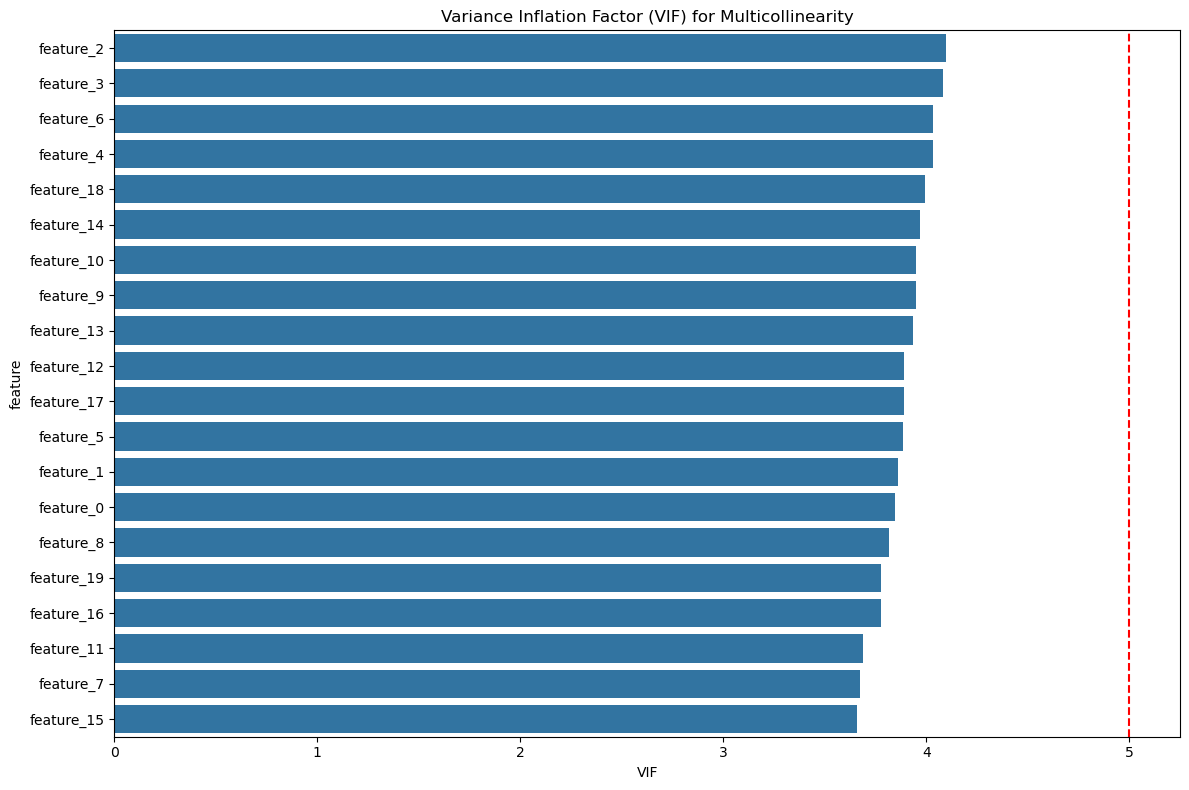

In [40]:
summary_stats, correlations, outliers_summary, feature_importance, normality_tests = analyze_dataframe(data)

* Features 2 has high correlation with dependent variable
* Features 13, 9, 11 have moderate correlation with dependent variable. The mentioned features should play significantly in model interpretation for model inference in production.
* Features have significantly different scales which suggests that feature scaling (e.g., standardization or normalization) is necessary to improve model performance.
* The target variable appears to have a much smaller spread compared to many features.
* Features with similar spreads and central tendencies like feature_2, feature_3, and feature_6 may indicate potential multicollinearity
* All features have VIF values below 5, meaning there is no severe multicollinearity issue among predictors. This is a good sign for model stability and interpretability.



In [ ]:
# general stats
summary_stats

count        mean         std       min         25%         50%  \
feature_0   800.0  468.181612  270.797415  0.916648  239.330140  477.750620   
feature_1   800.0  301.960218  170.691136  0.800119  157.338244  303.257176   
feature_2   800.0  317.132996  176.501920  0.173025  167.516318  326.310194   
feature_3   800.0  283.213456  157.698215  0.308823  151.302826  294.574403   
feature_4   800.0  485.975950  272.594030  0.598527  250.305362  493.470486   
feature_5   800.0  320.953859  185.157189  0.997347  158.374610  328.722464   
feature_6   800.0  217.136330  123.660691  0.402436  106.876625  217.098090   
feature_7   800.0  387.196289  235.131376  0.474825  195.037853  364.124238   
feature_8   800.0  179.485453  104.059309  0.727850   94.220273  173.364771   
feature_9   800.0  196.003058  111.042671  0.264253   95.052359  199.587048   
feature_10  800.0  401.079696  228.533579  1.487605  200.478981  413.806417   
feature_11  800.0    3.372667    1.986369  0.004464    1.630150    3.349497   
feature_12  800.0  479.841915  276.304197  1.706240  249.560260  468.536888   
feature_13  800.0  100.112096   59.149794  0.194306   48.132939  100.247827   
feature_14  800.0   28.334725   16.105155  0.222312   14.660437   27.953146   
feature_15  800.0  277.205999  167.385930  1.726915  131.516567  275.950814   
feature_16  800.0   91.217615   53.950523  0.093789   44.357970   87.484343   
feature_17  800.0   70.927129   40.588905  0.072986   34.903031   74.429675   
feature_18  800.0   27.385266   15.509062  0.101761   13.815298   27.766111   
feature_19  800.0  457.016407  270.650146  0.252919  221.270792  462.153497   
target      800.0   14.631342    5.089503  0.279805   10.879914   14.687955   

                   75%         max  missing  missing_pct  unique_values  
feature_0   704.650292  940.771543        0          0.0            800  
feature_1   448.878174  595.359858        0          0.0            800  
feature_2   474.484472  614.271632        0          0.0            800  
feature_3   415.806162  549.896216        0          0.0            800  
feature_4   720.747672  950.017444        0          0.0            800  
feature_5   480.076559  638.199832        0          0.0            800  
feature_6   327.411334  426.308251        0          0.0            800  
feature_7   588.565017  809.346792        0          0.0            800  
feature_8   268.790459  367.084755        0          0.0            800  
feature_9   291.546642  384.919108        0          0.0            800  
feature_10  614.042096  767.311089        0          0.0            800  
feature_11    5.024192    6.859269        0          0.0            800  
feature_12  713.291136  979.715063        0          0.0            800  
feature_13  149.966755  203.122292        0          0.0            800  
feature_14   42.514155   56.467485        0          0.0            800  
feature_15  423.110446  566.611509        0          0.0            800  
feature_16  137.888018  187.041256        0          0.0            800  
feature_17  105.484961  138.675389        0          0.0            800  
feature_18   40.402938   53.254740        0          0.0            800  
feature_19  688.352373  935.740775        0          0.0            800  
target       18.224713   27.360789        0          0.0            800

In [ ]:
summary_stats, correlations, outliers_summary, feature_importance, normality_tests

### Correlation Techniques

* Pearson Correlation: 
* Spearman Correlation:
* Kendall Correlation:
* P-Values (Correlation Significance):  

In [ ]:

def correlation_techniques(df, output_dir='data/eda/correlations/', save_plots=True):
    """
    Performs and visualizes multiple correlation techniques on a numeric dataframe.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing numeric data for correlation analysis
    output_dir : str, default='data/analysis_plots/correlations/'
        Directory where to save generated plots
    save_plots : bool, default=True
        Whether to save plots to disk
        
    Returns:
    --------
    tuple
        (pearson_corr, spearman_corr, kendall_corr, significant_correlations, correlation_comparison)
        All elements are pandas DataFrames containing correlation results
    """
    # Create directory if it doesn't exist and save_plots is True
    if save_plots and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create copy of dataframe to avoid modifying original
    df_corr = df.copy()
    
    # Calculate correlation matrices
    pearson_corr = df_corr.corr(method='pearson')
    spearman_corr = df_corr.corr(method='spearman')
    kendall_corr = df_corr.corr(method='kendall')
    
    # Calculate p-values for Pearson correlation
    pearson_p_values = pd.DataFrame(np.zeros_like(pearson_corr), 
                                   index=pearson_corr.index, 
                                   columns=pearson_corr.columns)
    
    # Calculate significance for Pearson correlations
    for i in range(len(pearson_corr.columns)):
        for j in range(len(pearson_corr.columns)):
            if i != j:  # Skip diagonal (self-correlations)
                stat, p = stats.pearsonr(df_corr.iloc[:, i].dropna(), 
                                          df_corr.iloc[:, j].dropna())
                pearson_p_values.iloc[i, j] = p
    
    # Create DataFrame for significant correlations
    significant_mask = (pearson_p_values < 0.05) & (pearson_p_values != 0)
    significant_correlations = pd.DataFrame({
        'feature1': [],
        'feature2': [],
        'pearson_corr': [],
        'spearman_corr': [],
        'kendall_corr': [],
        'p_value': [],
        'significant': []
    })
    
    # Find significant correlations (excluding self-correlations)
    sig_corr_rows = []
    for i in range(len(pearson_corr.columns)):
        for j in range(i+1, len(pearson_corr.columns)):  # Only upper triangle
            p_value = pearson_p_values.iloc[i, j]
            is_significant = significant_mask.iloc[i, j]
            
            sig_corr_rows.append({
                'feature1': pearson_corr.columns[i],
                'feature2': pearson_corr.columns[j],
                'pearson_corr': pearson_corr.iloc[i, j],
                'spearman_corr': spearman_corr.iloc[i, j],
                'kendall_corr': kendall_corr.iloc[i, j],
                'p_value': p_value,
                'significant': is_significant
            })
    
    significant_correlations = pd.DataFrame(sig_corr_rows).sort_values('pearson_corr', 
                                                                        key=abs, 
                                                                        ascending=False)
    
    # Create correlation comparison dataframe
    correlation_comparison = pd.DataFrame({
        'feature_pair': [f"{row['feature1']} - {row['feature2']}" for _, row in significant_correlations.iterrows()],
        'pearson': significant_correlations['pearson_corr'],
        'spearman': significant_correlations['spearman_corr'],
        'kendall': significant_correlations['kendall_corr']
    })
    
    # Visualizations
    print("Generating correlation visualizations...")
    
    # 1. Pearson correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(pearson_corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.title('Pearson Correlation Coefficient\n(Linear relationship)')
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}pearson_correlation.png", dpi=300, bbox_inches='tight')
    
    # 2. Spearman correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(spearman_corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(spearman_corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.title('Spearman Rank Correlation\n(Monotonic relationship)')
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}spearman_correlation.png", dpi=300, bbox_inches='tight')
    
    # 3. Kendall correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(kendall_corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(kendall_corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.title('Kendall Tau Correlation\n(Ordinal correlation)')
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}kendall_correlation.png", dpi=300, bbox_inches='tight')
    
    # 4. Correlation significance visualization
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(pearson_p_values, dtype=bool))
    
    # Create a custom colormap for p-values (green for significant, red for non-significant)
    significant_cmap = plt.cm.RdYlGn_r
    
    # Plot p-values heatmap
    sns.heatmap(pearson_p_values, mask=mask, cmap=significant_cmap, 
                annot=True, square=True, linewidths=.5, 
                cbar_kws={"shrink": .5, "label": "p-value"}, 
                vmin=0, vmax=0.10)
    
    plt.title('Correlation Significance (p-values)\nValues < 0.05 are statistically significant')
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}correlation_significance.png", dpi=300, bbox_inches='tight')
    
    # 5. Top 10 strongest correlations bar chart
    plt.figure(figsize=(14, 8))
    top_correlations = significant_correlations.head(10).copy()
    top_correlations['abs_pearson'] = abs(top_correlations['pearson_corr'])
    top_correlations = top_correlations.sort_values('abs_pearson', ascending=True)
    
    bars = plt.barh(
        [f"{row['feature1']} - {row['feature2']}" for _, row in top_correlations.iterrows()],
        top_correlations['pearson_corr'],
        color=[plt.cm.RdBu(int((corr + 1) * 0.5 * 255)) for corr in top_correlations['pearson_corr']]
    )
    
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Pearson Correlation Coefficient')
    plt.title('Top 10 Strongest Feature Correlations')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}top_correlations.png", dpi=300, bbox_inches='tight')
    
    # 6. Correlation methods comparison for top features
    top_features_comparison = correlation_comparison.head(10)
    
    # Reshape for plotting
    top_features_comparison_melted = pd.melt(
        top_features_comparison, 
        id_vars=['feature_pair'], 
        value_vars=['pearson', 'spearman', 'kendall'],
        var_name='method', 
        value_name='correlation'
    )
    
    plt.figure(figsize=(14, 10))
    sns.barplot(x='correlation', y='feature_pair', hue='method', 
                data=top_features_comparison_melted,
                palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
    
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Comparison of Correlation Methods for Top Feature Pairs')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Feature Pair')
    plt.legend(title='Correlation Method')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}correlation_methods_comparison.png", dpi=300, bbox_inches='tight')
    
    # 7. Scatterplot matrix for top correlated features
    if significant_correlations.shape[0] > 0:
        # Get top correlated features (unique list from top 5 correlations)
        top_feature_pairs = significant_correlations.head(5)
        top_features = set()
        for _, row in top_feature_pairs.iterrows():
            top_features.add(row['feature1'])
            top_features.add(row['feature2'])
        
        top_features = list(top_features)[:5]  # Limit to 5 features for clarity
        
        if len(top_features) >= 2:
            plt.figure(figsize=(15, 15))
            scatter_plot = sns.pairplot(
                df_corr[top_features], 
                kind='scatter', 
                diag_kind='kde',
                plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k', 'linewidth': 0.5},
                diag_kws={'fill': True, 'linewidth': 1, 'alpha': 0.8}
            )
            
            # Add correlation coefficient to each scatter plot
            for i, j in zip(*np.triu_indices_from(scatter_plot.axes, k=1)):
                ax = scatter_plot.axes[i, j]
                x = df_corr[top_features].columns[j]
                y = df_corr[top_features].columns[i]
                
                pearson_r = stats.pearsonr(df_corr[x].dropna(), df_corr[y].dropna())[0]
                spearman_r = stats.spearmanr(df_corr[x].dropna(), df_corr[y].dropna())[0]
                
                ax.annotate(f'Pearson: {pearson_r:.2f}\nSpearman: {spearman_r:.2f}', 
                            xy=(0.05, 0.95), xycoords='axes fraction',
                            ha='left', va='top',
                            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))
            
            plt.suptitle('Scatter Matrix of Top Correlated Features', y=1.02, fontsize=16)
            
            if save_plots:
                plt.savefig(f"{output_dir}top_features_pairplot.png", dpi=300, bbox_inches='tight')
    
    # Show plots if not saving
    if not save_plots:
        plt.show()
    
    print("Correlation analysis complete!")
    
    return (pearson_corr, spearman_corr, kendall_corr, significant_correlations, correlation_comparison)

Generating correlation visualizations...
Correlation analysis complete!


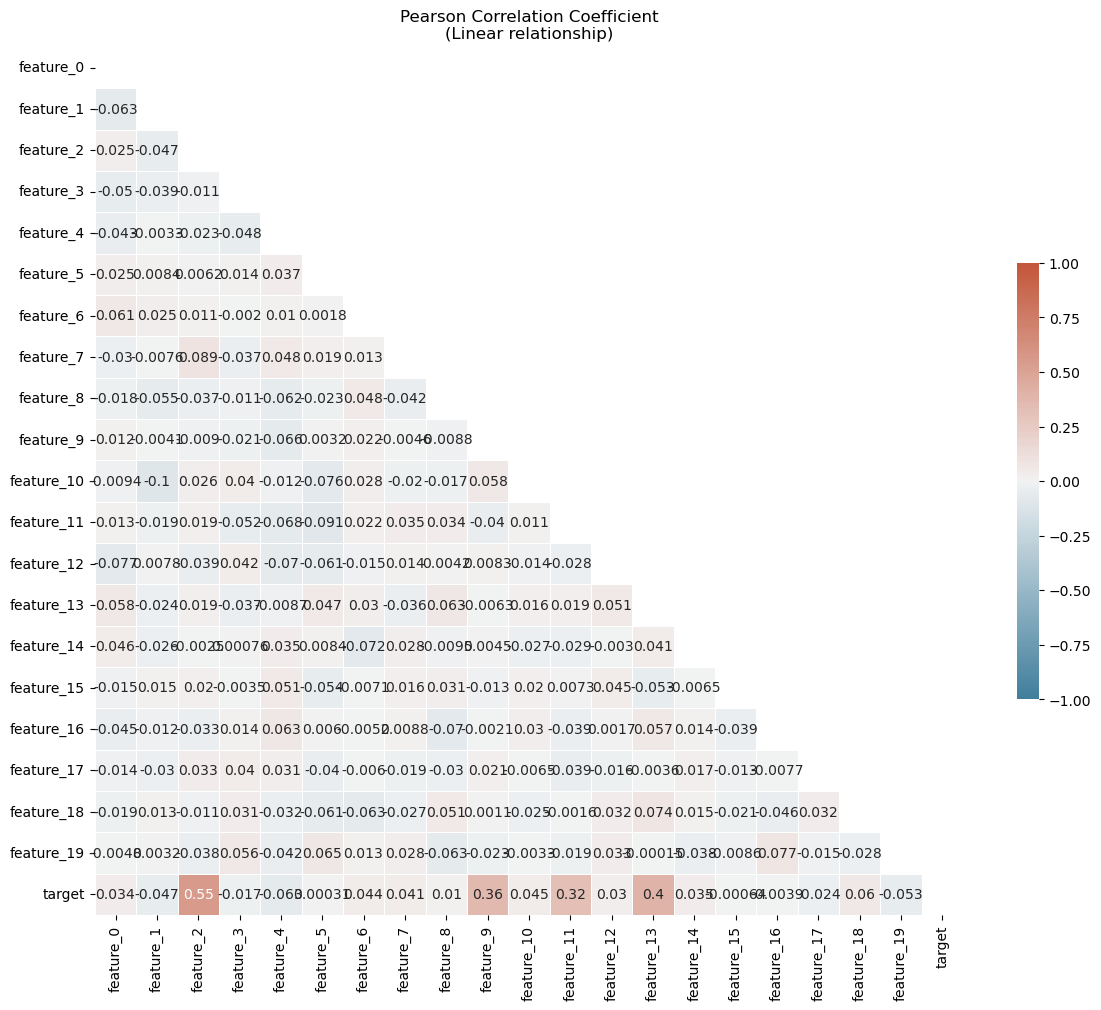

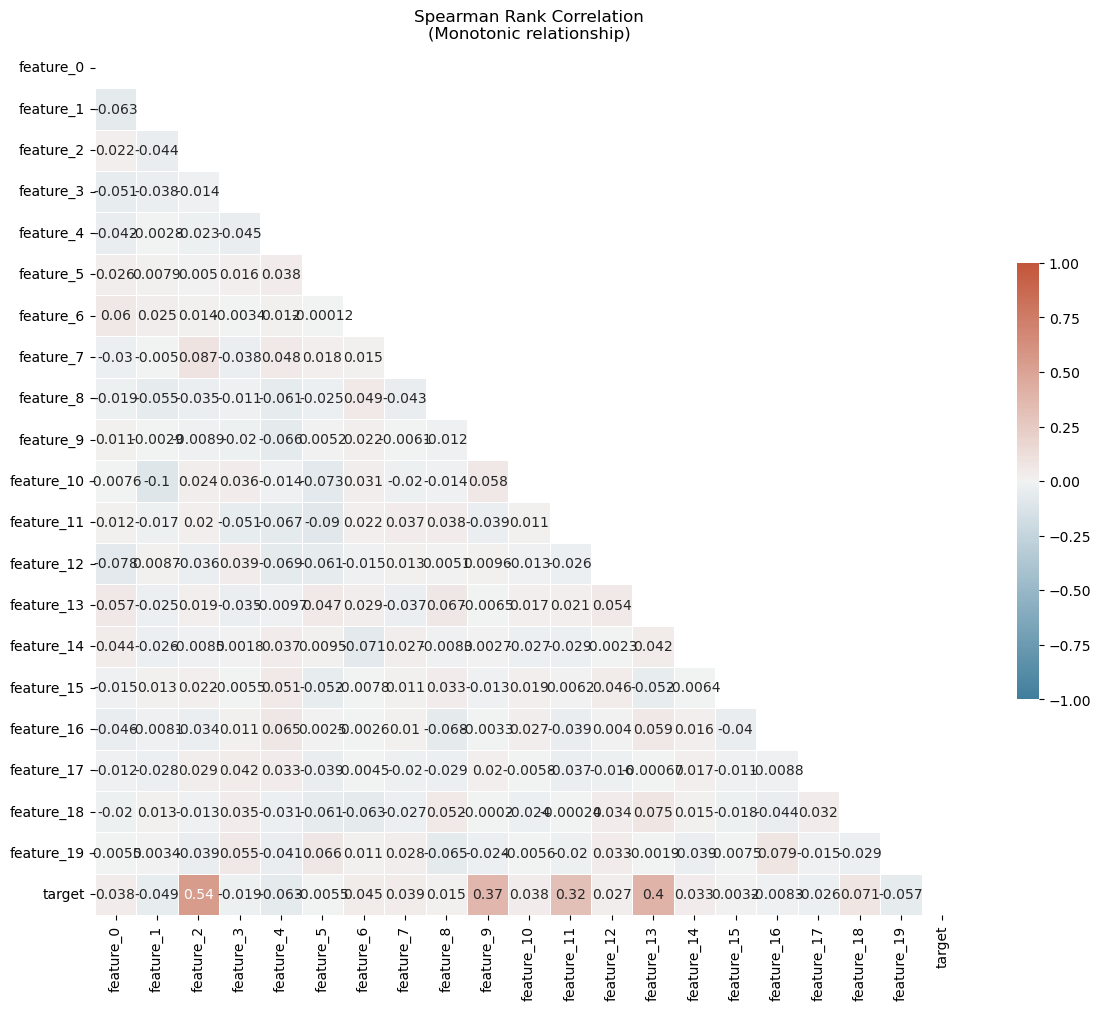

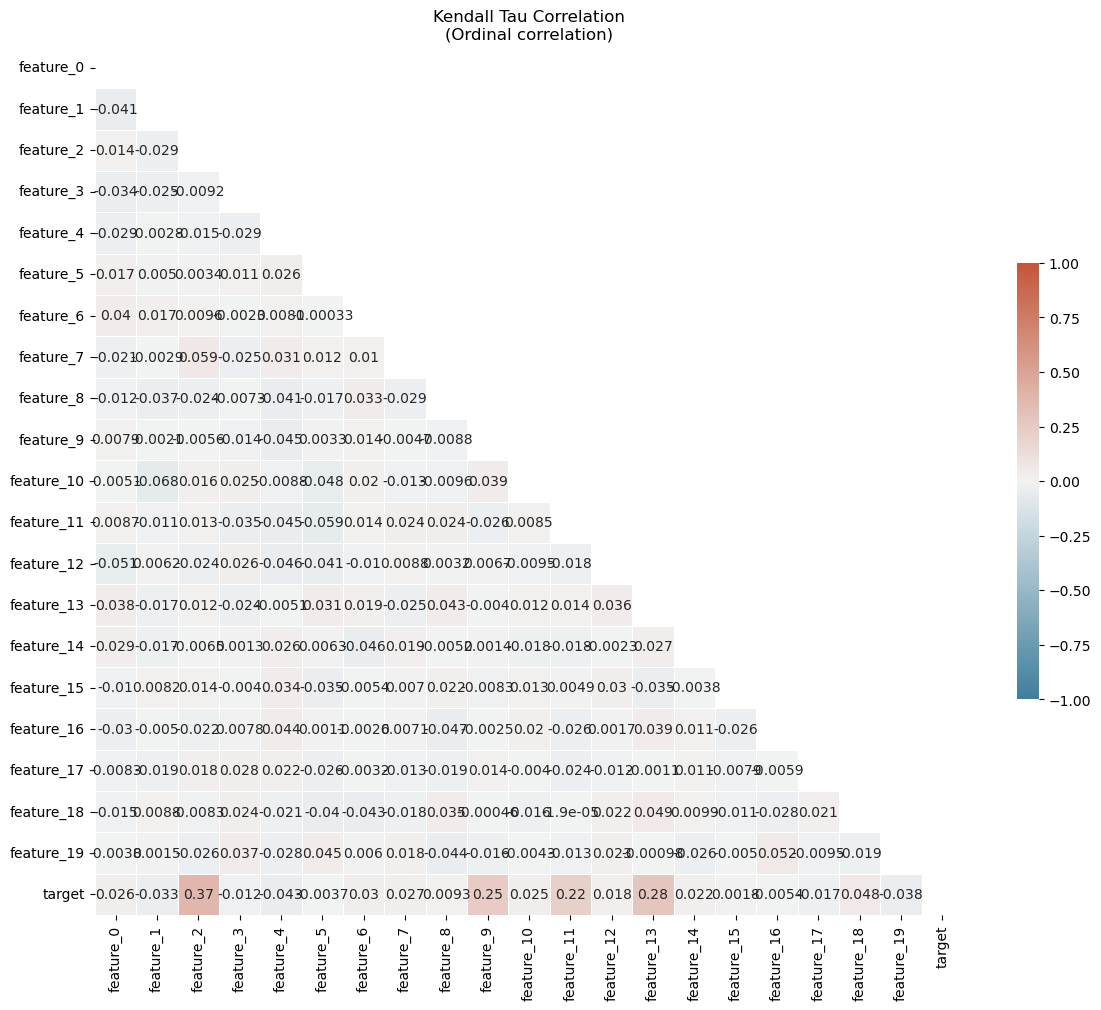

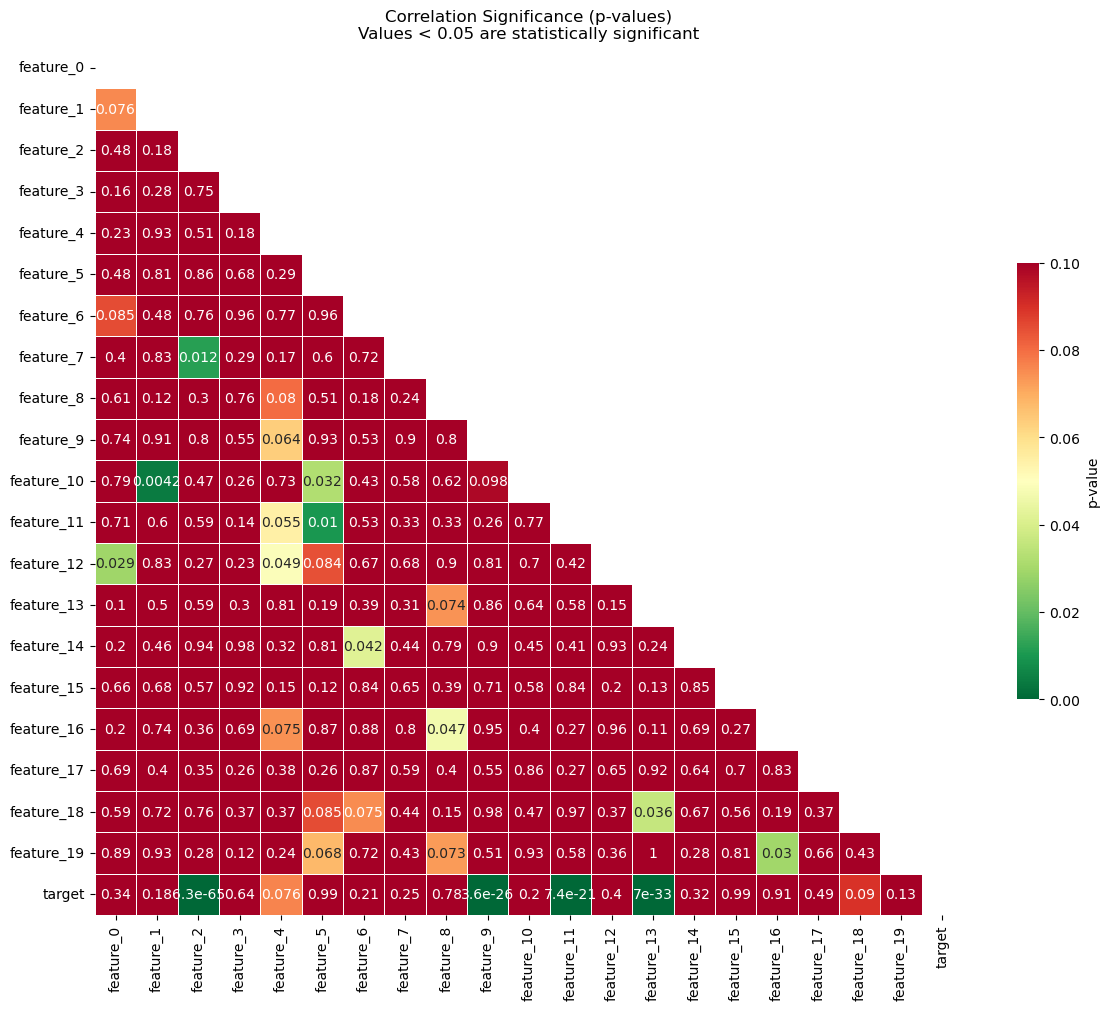

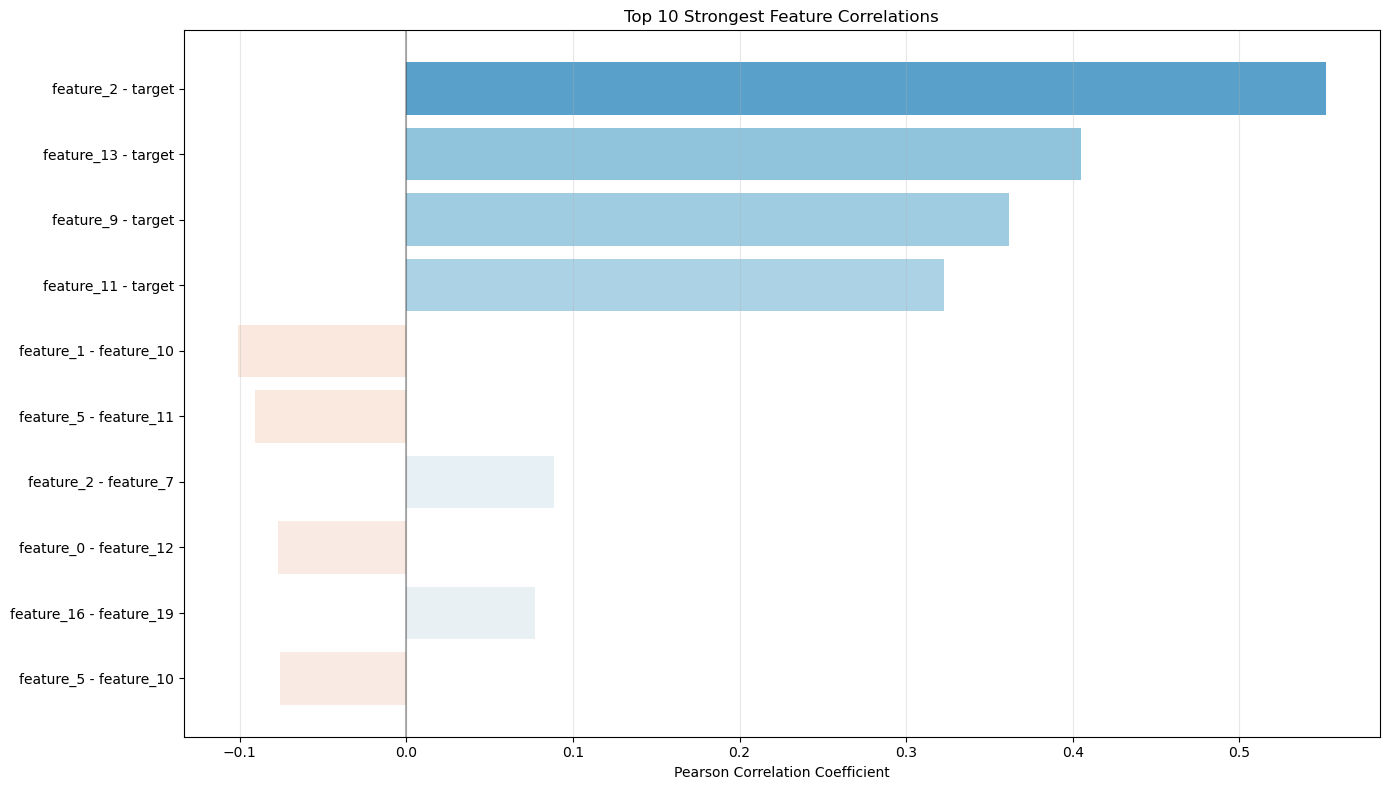

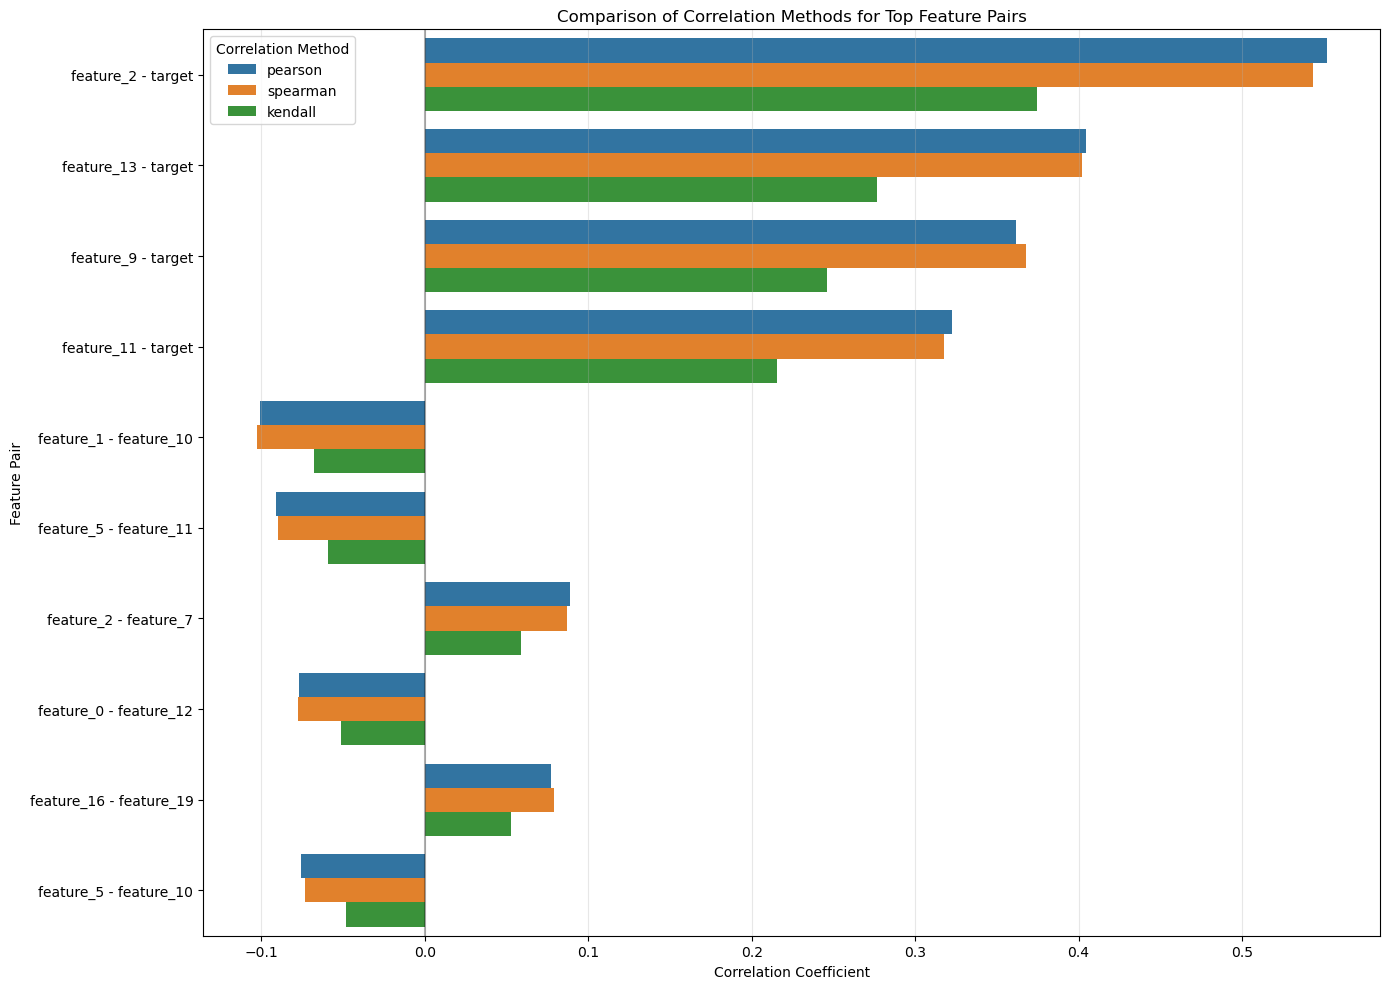

<Figure size 1500x1500 with 0 Axes>

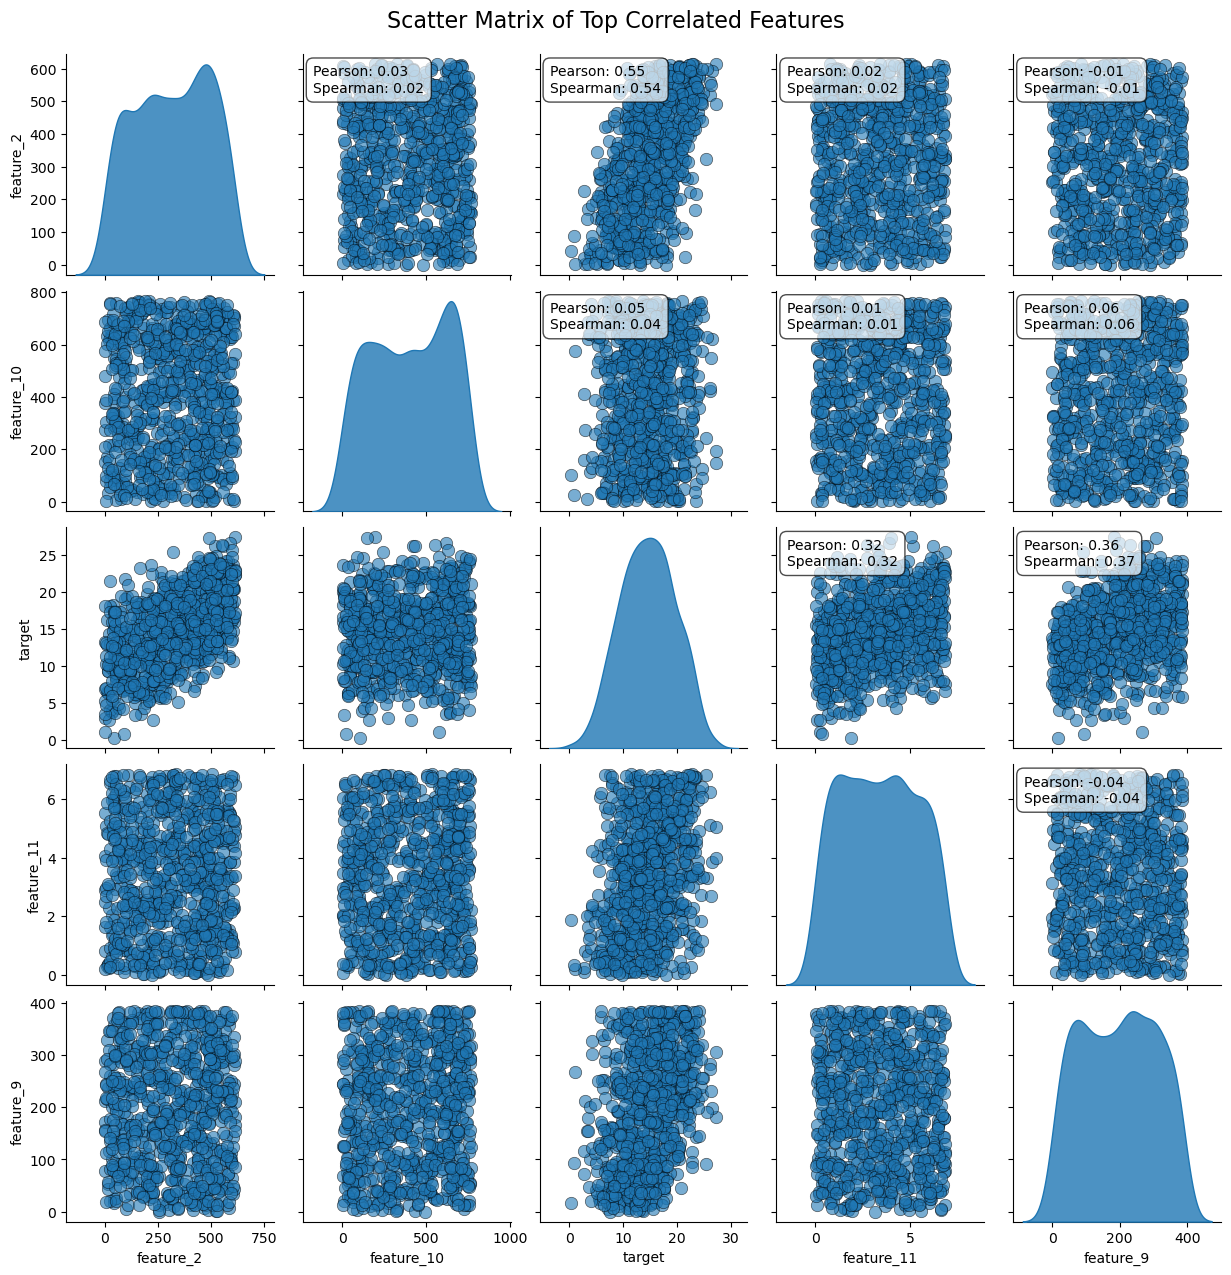

In [ ]:
(pearson_corr, spearman_corr, kendall_corr, significant_correlations, correlation_comparison) = correlation_techniques(data)

* Feature_2, Feature_10, Feature_13: These have the highest Pearson correlation with the target (~0.55, 0.36, 0.4 respectively) and very low p-values (< 0.05), making them strong candidates for predictive modeling.
Feature_11 (0.32 correlation, p < 0.05) is also statistically significant.

* Features like Feature_0, Feature_5, Feature_6, Feature_15, Feature_18, and Feature_19 have high p-values (> 0.05), indicating no statistically significant correlation with the target.

### Variance and Covariance

In [ ]:
def analyze_variance(df, output_dir='data/eda/variance/', save_plots=True):
    """
    Perform variance and covariance analysis on a pandas DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing numerical data for analysis
    output_dir : str, default='data/analysis_plots/variance/'
        Directory to save generated plots
    save_plots : bool, default=True
        Whether to save the generated plots
        
    Returns:
    --------
    tuple : (variance_df, covariance_df, correlation_df)
        Three DataFrames containing variance, covariance, and correlation information
    """
    # Create output directory if it doesn't exist and save_plots is True
    if save_plots:
        Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Select only numeric columns for analysis
    numeric_df = df.select_dtypes(include=[np.number])
    
    if numeric_df.empty:
        raise ValueError("No numeric columns found in the DataFrame")
    
    # Calculate variance for each numeric column
    variance_df = pd.DataFrame({
        'column': numeric_df.columns,
        'variance': numeric_df.var(),
        'std_deviation': numeric_df.std(),
        'mean': numeric_df.mean(),
        'median': numeric_df.median(),
        'min': numeric_df.min(),
        'max': numeric_df.max(),
        'range': numeric_df.max() - numeric_df.min(),
        'iqr': numeric_df.quantile(0.75) - numeric_df.quantile(0.25)
    }).reset_index(drop=True)
    
    # Calculate covariance matrix
    covariance_matrix = numeric_df.cov()
    
    # Calculate correlation matrix
    correlation_matrix = numeric_df.corr()
    
    # Visualizations
    
    # 1. Variance bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='column', y='variance', data=variance_df)
    plt.title('Variance by Column')
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(output_dir, 'variance_barplot.png'))
    plt.show()
    
    # 2. Box plots for distribution and variance visualization
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=numeric_df)
    plt.title('Distribution and Variance Across Columns')
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(output_dir, 'boxplot_distribution.png'))
    plt.show()
    
    # 3. Heatmap of covariance matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Covariance Matrix Heatmap')
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(output_dir, 'covariance_heatmap.png'))
    plt.show()
    
    # 5. Pairplot for multi-variable relationships
    if len(numeric_df.columns) <= 10:  # Only create pairplot if there aren't too many columns
        plt.figure(figsize=(16, 14))
        pairplot = sns.pairplot(numeric_df)
        plt.suptitle('Pairwise Relationships', y=1.02)
        if save_plots:
            pairplot.savefig(os.path.join(output_dir, 'pairplot.png'))
        plt.show()
    
    # 6. Standard deviation comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='column', y='std_deviation', data=variance_df)
    plt.title('Standard Deviation by Column')
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(output_dir, 'std_deviation_barplot.png'))
    plt.show()
    
    # Return the summary dataframes
    return variance_df, covariance_matrix

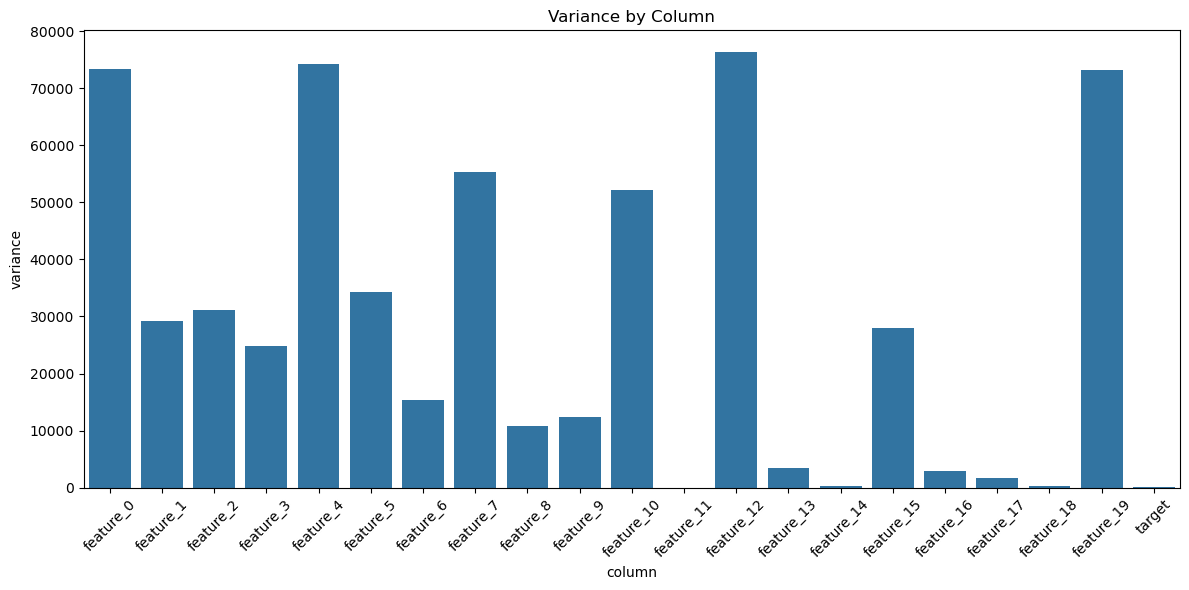

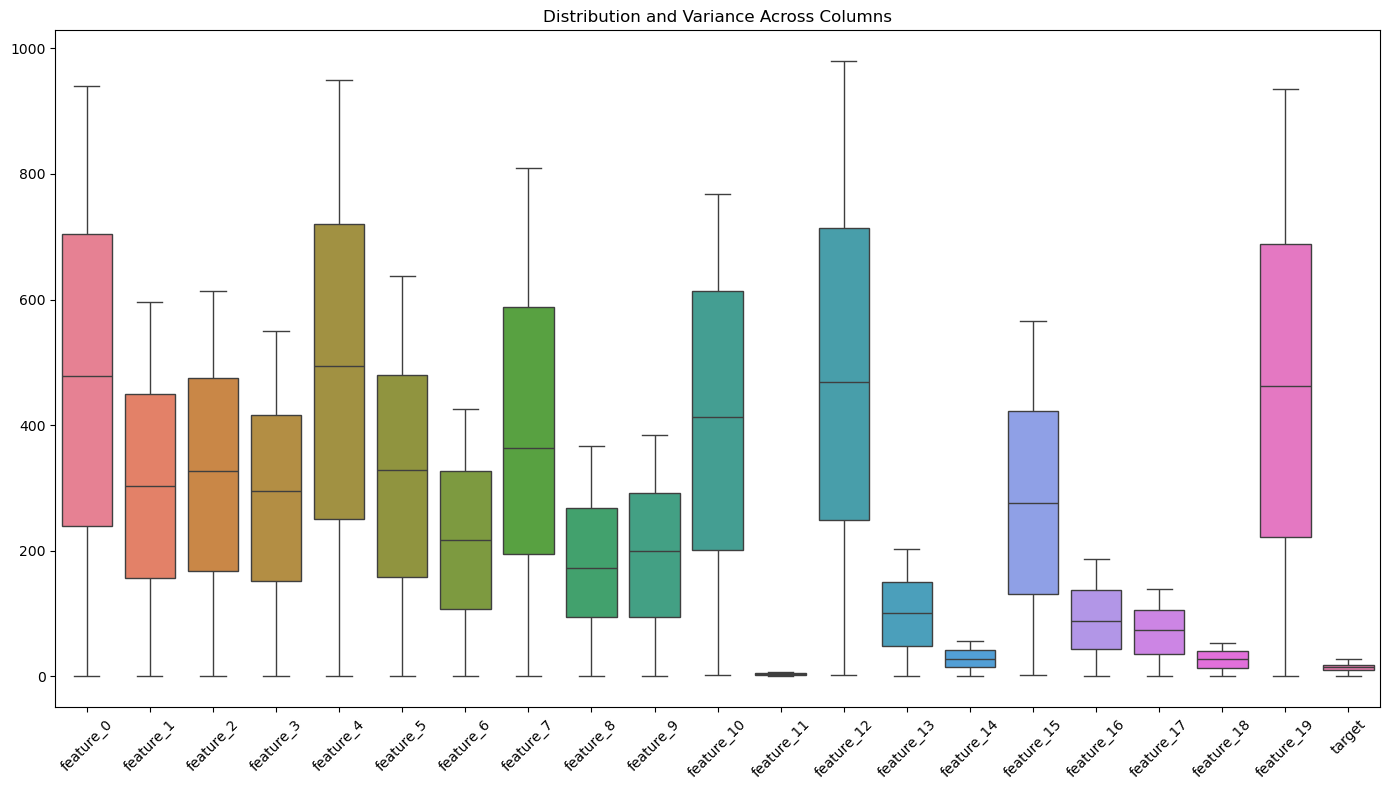

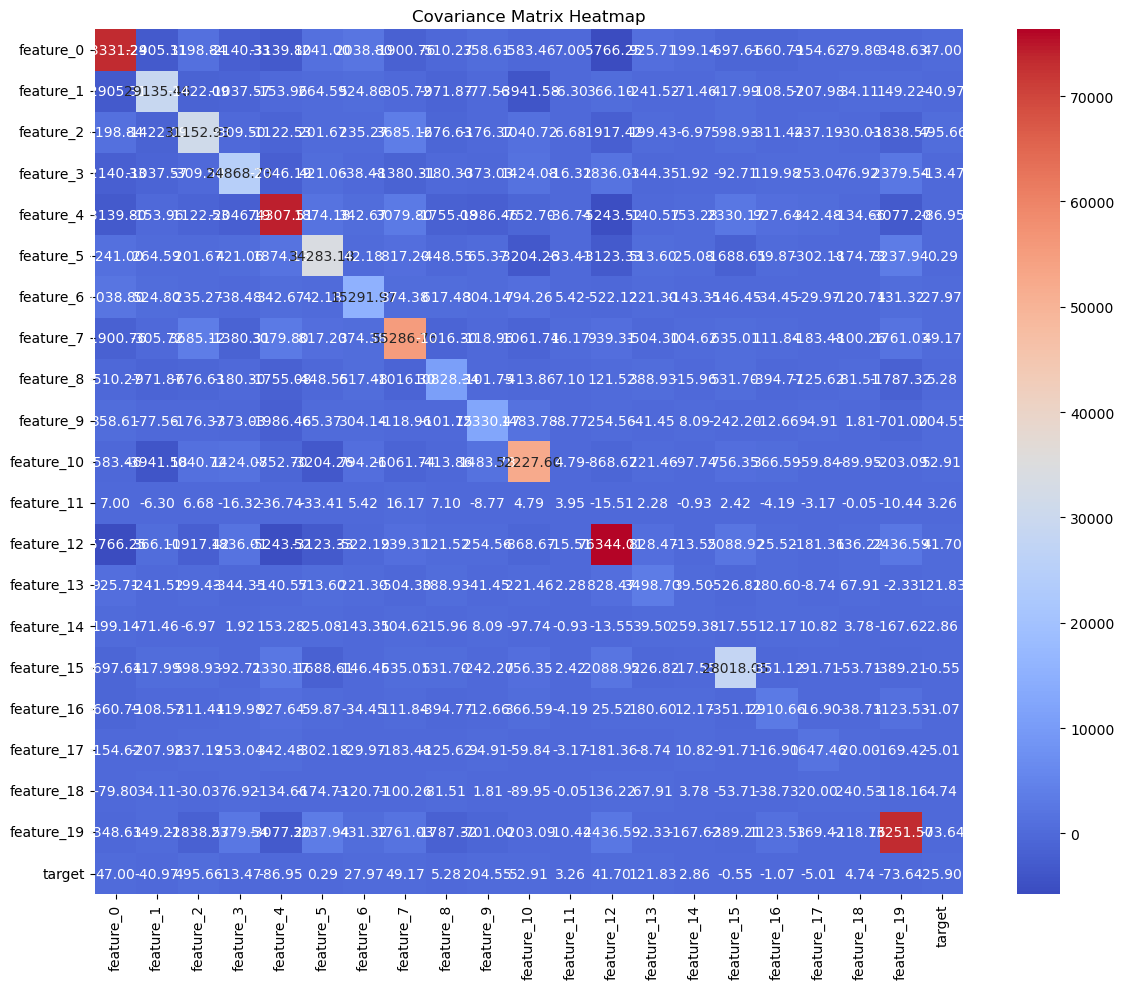

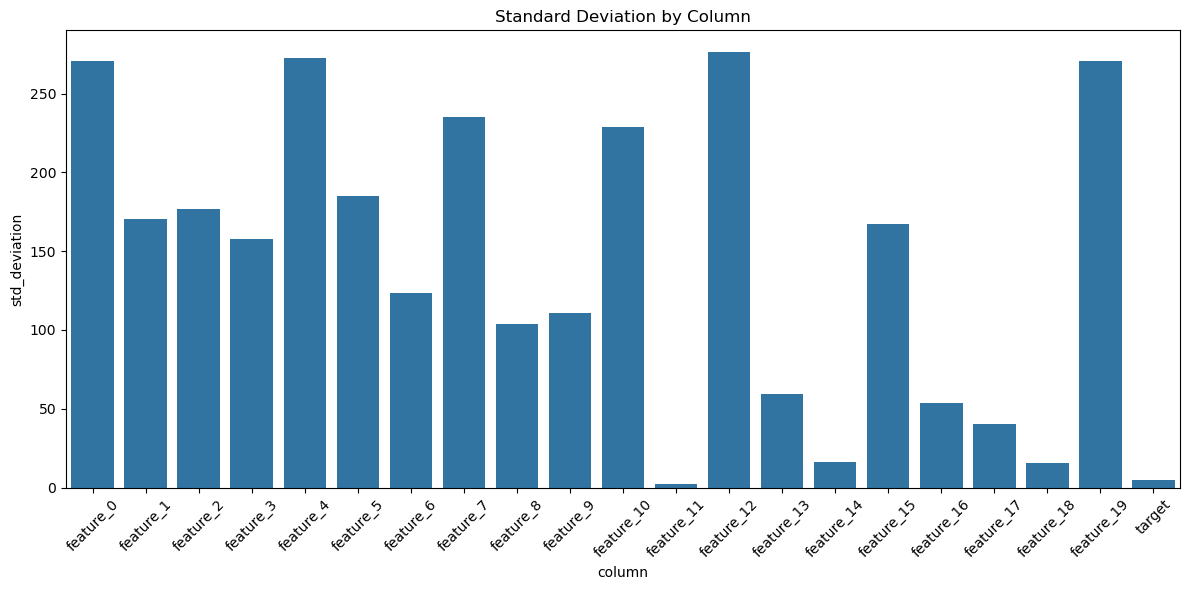

In [ ]:
variance_df, covariance_matrix = analyze_variance(data)

### Pairplot

In [ ]:
def visualize_numeric_data(df, output_dir='data/eda/pairplot/', save_plots=True):
    """
    Applies pairplot and scatter plot on a tabular numeric dataset.
    
    Parameters:
    - df: pandas DataFrame, the input dataset containing numeric columns.
    - output_dir: str, the directory where plots will be saved. Default is 'data/eda/pairplot/'.
    - save_plots: bool, whether to save the plots or not. Default is True.
    
    Returns:
    - tuple: (key_insights, df)
      - key_insights: pandas DataFrame, containing key insights from the dataset.
      - df: pandas DataFrame, the original dataset.
    """
    
    # Ensure the output directory exists
    if save_plots and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Pairplot
    pairplot_path = os.path.join(output_dir, 'pairplot.png')
    sns.pairplot(df)
    if save_plots:
        plt.savefig(pairplot_path)
    plt.close()
    
    # Scatter plot for each pair of numeric columns
    scatter_plots_dir = os.path.join(output_dir, 'scatter_plots')
    if save_plots and not os.path.exists(scatter_plots_dir):
        os.makedirs(scatter_plots_dir)
    
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for i in range(len(numeric_columns)):
        for j in range(i + 1, len(numeric_columns)):
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=df[numeric_columns[i]], y=df[numeric_columns[j]])
            plt.title(f'Scatter Plot: {numeric_columns[i]} vs {numeric_columns[j]}')
            if save_plots:
                scatter_plot_path = os.path.join(scatter_plots_dir, f'scatter_{numeric_columns[i]}_vs_{numeric_columns[j]}.png')
                plt.savefig(scatter_plot_path)
            plt.close()
    
    # Generate key insights
    key_insights = df.describe().transpose()
    key_insights['skewness'] = df.skew()
    key_insights['kurtosis'] = df.kurt()
    
    return key_insights, df

# Example usage:
# df = pd.read_csv('your_dataset.csv')
# insights, data = visualize_numeric_data(df)

In [ ]:
key_insights, _ = visualize_numeric_data(data)

In [ ]:
key_insights

### Distribution Analysis

### Statistical Tests

### Unsupervised Learning

### Outlier Detection

## Preprocessing

In [112]:
# load tabular data from bronze layer
data = pd.read_csv('data/bronze/data_bronze.csv')
data

feature_0   feature_1   feature_2   feature_3   feature_4   feature_5  \
0    432.475954  289.373016  481.315600  358.755566  802.659004  176.761177   
1    517.596250  330.448341  585.920055   22.684031  169.813240  335.601640   
2    189.439350  553.888820  165.833790  202.465927  176.695586  321.155049   
3    237.307878  195.894881  416.752252  468.729031  611.693517  301.411711   
4    602.845256   16.103208  221.759979  345.765574  558.588369  276.704241   
..          ...         ...         ...         ...         ...         ...   
795  939.158462  553.881664  543.088541   71.556673  354.225260  343.143913   
796  489.373311   13.531758  120.387215  187.544473  409.964275  523.310429   
797  936.496031  140.148546  213.454901  461.841364   86.759083   53.081953   
798  783.876505  477.530653  216.890295  175.429988  348.212630  593.979057   
799  254.474296  495.544668   34.479751   54.297075  811.985275  350.692940   

      feature_6   feature_7   feature_8   feature_9  ...  feature_11  \
0     72.648102  720.969179   36.327684   83.768878  ...    4.385848   
1    284.451476  748.101047   73.701438  358.147215  ...    5.563334   
2    407.278389  161.245668  282.269025  221.570899  ...    4.536947   
3    241.880655   49.597044  122.396821   13.828319  ...    5.518968   
4    408.069566   19.390813  138.769765  146.662193  ...    2.136214   
..          ...         ...         ...         ...  ...         ...   
795  233.732499  420.369307  362.371947  310.233672  ...    3.666136   
796  256.719030  341.095062   55.850912  383.027048  ...    3.443595   
797  241.042320  379.023230  140.241770  306.861602  ...    4.356944   
798   55.137074  226.367598  329.873123  302.451012  ...    3.849649   
799  369.315943  468.817211  335.527591  119.782274  ...    6.225934   

     feature_12  feature_13  feature_14  feature_15  feature_16  feature_17  \
0    516.789458   19.624422   13.162440   42.351948   35.920392   20.755984   
1      2.960064   20.721878   17.740184    1.726915  167.576065   75.492679   
2    581.823741  101.695639    0.653592  486.859084  117.491548    6.420465   
3     45.014729  196.350455   47.638515  411.414213   67.142022  115.630943   
4    133.590430  197.634584   26.278027  111.127557  172.181136   85.869642   
..          ...         ...         ...         ...         ...         ...   
795  713.540081  158.829853   25.995461  143.293235  127.731367  122.722659   
796  397.801688  110.880683   17.123976  284.277940  111.041401  124.447221   
797  876.638733   43.728076   17.400287  556.740895  100.203033   98.565669   
798  324.661269   38.852525   46.472905  352.709718   96.373785  114.783223   
799  128.796394   20.024934   10.509060  427.083047   98.249054   23.038458   

     feature_18  feature_19     target  
0     13.814300  384.497136  14.364922  
1      2.480979  303.710869  19.984801  
2     20.713314   22.651537  12.944351  
3      8.927957  388.240433  14.792440  
4     30.537857  625.931837  11.802634  
..          ...         ...        ...  
795   48.910185  298.725020  23.716818  
796   49.888743  212.752488  16.515457  
797   44.833075  844.393623  12.642383  
798   51.264147  703.326040  16.186675  
799   40.086942  350.740846   5.944792  

[800 rows x 21 columns]

### Data Cleaning

No missing values/NULL values in data features

In [113]:
# calcular porcentaje de missing values y NULLs en cada columna
porcentaje_missing = data.isna().mean() * 100

# Sort the variables by missing percentage in descending order
porcentaje_missing.sort_values(ascending=False, inplace=True)

# ver variables por porcentaje de NA/NULL
print('porcentaje missing NA',porcentaje_missing)

porcentaje missing NA feature_0     0.0
feature_11    0.0
feature_19    0.0
feature_18    0.0
feature_17    0.0
feature_16    0.0
feature_15    0.0
feature_14    0.0
feature_13    0.0
feature_12    0.0
feature_10    0.0
feature_1     0.0
feature_9     0.0
feature_8     0.0
feature_7     0.0
feature_6     0.0
feature_5     0.0
feature_4     0.0
feature_3     0.0
feature_2     0.0
target        0.0
dtype: float64


### x features - y target

In [114]:
def prepare_regression_data(df, target_label = 'target'):
    """
    Prepares feature matrix (X) and target vector (y) for regression tasks.

    Parameters:
    - df: pandas DataFrame, the input dataset.
    - target_label: str, the name of the target column in the DataFrame.

    Returns:
    - X: pandas DataFrame, the feature matrix (independent variables).
    - y: pandas Series, the target vector (dependent variable).
    """
    
    # Ensure the target label exists in the DataFrame
    if target_label not in df.columns:
        raise ValueError(f"Target label '{target_label}' not found in the DataFrame columns.")
    
    # Select features (X) by dropping the target column
    X = df.drop(columns=[target_label])
    
    # Select target (y)
    y = df[target_label]
    
    return X, y

In [115]:
x, y = prepare_regression_data(data)

### Training Testing Datasets Split

In [116]:
def split_data(x, y, test_size=0.2, random_state=1):
    """
    Split features and target into train and test sets.
    
    Parameters:
    -----------
    x : pandas.DataFrame
        DataFrame containing the features
    y : pandas.DataFrame
        DataFrame containing the numeric target (dependent variable)
    test_size : float, default=0.2
        Proportion of the dataset to include in the test split
    random_state : int, default=1
        Controls the shuffling applied to the data before applying the split
    
    Returns:
    --------
    x_train : pandas.DataFrame
        Training features
    x_test : pandas.DataFrame
        Testing features
    y_train : pandas.DataFrame
        Training target
    y_test : pandas.DataFrame
        Testing target
    """
    
    # Apply train_test_split to the data
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=random_state
    )
    
    return x_train, x_test, y_train, y_test

In [117]:
x_train, x_test, y_train, y_test = split_data(x, y)

### Standarization

In [118]:
def standardize(x_train, x_test, numeric_variables=None, output_dir='data/gold/scaler'):
    """
    Function that standardizes numeric variables of training and test sets using StandardScaler.
    The scaler is fitted only on training data and applied to both training and test sets.
    
    Parameters:
    -----------
    x_train : pandas.DataFrame
        Training DataFrame containing the features to standardize.
    x_test : pandas.DataFrame
        Test DataFrame containing the features to standardize.
    numeric_variables : list, default=None
        List with the names of the numeric columns to standardize.
        If None, all columns in the DataFrames will be standardized.
    output_dir : str, default='data/gold/scaler'
        Directory path where the fitted scaler object will be saved.
        
    Returns:
    --------
    x_train_scaled : pandas.DataFrame
        Training DataFrame with standardized features.
    x_test_scaled : pandas.DataFrame
        Test DataFrame with standardized features.
    scaler : StandardScaler
        The fitted StandardScaler object.
    """
    
    # If numeric_variables is not provided, use all columns
    if numeric_variables is None:
        numeric_variables = list(x_train.columns)
    
    # Create Pipeline with StandardScaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    # Create ColumnTransformer to apply transformation only to numeric columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_variables)
        ],
        remainder='passthrough'  # Leave the rest of the columns unchanged
    )
    
    # Fit the transformer on training data only
    preprocessor.fit(x_train)
    
    # Apply the transformation to both training and test data
    x_train_transformed = preprocessor.transform(x_train)
    x_test_transformed = preprocessor.transform(x_test)
    
    # Get names of columns that won't be transformed
    other_columns = [col for col in x_train.columns if col not in numeric_variables]
    
    # Create DataFrames with the transformed data
    # First come the transformed columns and then those that remain unchanged
    final_columns = numeric_variables + other_columns
    x_train_scaled = pd.DataFrame(x_train_transformed, columns=final_columns, index=x_train.index)
    x_test_scaled = pd.DataFrame(x_test_transformed, columns=final_columns, index=x_test.index)
    
    # Extract the StandardScaler object from the pipeline
    scaler = preprocessor.named_transformers_['num'].named_steps['scaler']
    
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the scaler object
    scaler_path = os.path.join(output_dir, 'standard_scaler.pkl')
    joblib.dump(scaler, scaler_path)
    
    return x_train_scaled, x_test_scaled, scaler

In [119]:
x_train_scaled, x_test_scaled, scaler = standardize(x_train, x_test)

In [120]:
"""
def standardize(df, numeric_variables):
    
    
    # Create Pipeline with StandardScaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    # Create ColumnTransformer to apply transformation only to numeric columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_variables)
        ],
        remainder='passthrough'  # Leave the rest of the columns unchanged
    )
    
    # Apply the transformation
    transformed_data = preprocessor.fit_transform(df)
    
    # Get names of columns that won't be transformed
    other_columns = [col for col in df.columns if col not in numeric_variables]
    
    # Create a new DataFrame with the transformed data
    # First come the transformed columns and then those that remain unchanged
    final_columns = numeric_variables + other_columns
    standardized_df = pd.DataFrame(transformed_data, columns=final_columns, index=df.index)
    
    return standardized_df
    
    
# standarize all feature columns (everything except 'target')
all_columns = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 
               'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 
               'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 
               'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 
               'target']

# Extract all features except the target
features_to_standardize = [col for col in all_columns if col != 'target']

standardized_df = standardize(data, features_to_standardize)
standardized_df
    
"""

"\ndef standardize(df, numeric_variables):\n    \n    \n    # Create Pipeline with StandardScaler\n    numeric_transformer = Pipeline(steps=[\n        ('scaler', StandardScaler())\n    ])\n    \n    # Create ColumnTransformer to apply transformation only to numeric columns\n    preprocessor = ColumnTransformer(\n        transformers=[\n            ('num', numeric_transformer, numeric_variables)\n        ],\n        remainder='passthrough'  # Leave the rest of the columns unchanged\n    )\n    \n    # Apply the transformation\n    transformed_data = preprocessor.fit_transform(df)\n    \n    # Get names of columns that won't be transformed\n    other_columns = [col for col in df.columns if col not in numeric_variables]\n    \n    # Create a new DataFrame with the transformed data\n    # First come the transformed columns and then those that remain unchanged\n    final_columns = numeric_variables + other_columns\n    standardized_df = pd.DataFrame(transformed_data, columns=final_columns, 

In [121]:
# Define the directory path
directory = 'data/silver'

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the file
x_train_scaled.to_csv(f'{directory}/x_train_scaled.csv', index=False)
y_train.to_csv(f'{directory}/y_train.csv', index=False)

x_test_scaled.to_csv(f'{directory}/x_test_scaled.csv', index=False)
y_test.to_csv(f'{directory}/y_test.csv', index=False)

## Model Training

In [260]:
# load processed training data (silver layer)
x_train_scaled = pd.read_csv('data/silver/x_train_scaled.csv')
y_train = pd.read_csv('data/silver/y_train.csv')

# load processed test data (silver layer)
x_test_scaled = pd.read_csv('data/silver/x_test_scaled.csv')
y_test = pd.read_csv('data/silver/y_test.csv')

### Optuna

#### Objective: Optimization Metric

In [ ]:
def objective(trial, X, y, model_name, cv=5):
    """
    Optuna objective function for hyperparameter tuning of tree-based models.

    Parameters:
    - trial: optuna.Trial, the trial object for hyperparameter optimization.
    - X: pandas DataFrame or numpy array, the feature matrix.
    - y: pandas Series or numpy array, the target variable.
    - model_name: str, the name of the model to optimize ('rf', 'xgb', 'lgb', 'cat').

    Returns:
    - float, the mean squared error (MSE) from cross-validation.
    """
    if model_name == "rf":
        # Random Forest hyperparameters
        bootstrap = trial.suggest_categorical("bootstrap", [True, False])
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
            "max_depth": trial.suggest_int("max_depth", 3, 50),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap": bootstrap,
        }
        if bootstrap:
            params["max_samples"] = trial.suggest_float("max_samples", 0.5, 1.0)
            params["oob_score"] = trial.suggest_categorical("oob_score", [True, False])
        model = RandomForestRegressor(**params, n_jobs=-1, random_state=1)

    elif model_name == "xgb":
        # XGBoost hyperparameters
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 10),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.1, 10),
        }
        model = XGBRegressor(**params, n_jobs=-1, random_state=1, verbosity=0)

    elif model_name == "lgb":
        # LightGBM hyperparameters
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 20, 200),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
            "min_split_gain": trial.suggest_float("min_split_gain", 0, 1),
        }
        model = LGBMRegressor(**params, n_jobs=-1, random_state=1, verbose=-1)

    elif model_name == "cat":
        # CatBoost hyperparameters
        params = {
            "iterations": trial.suggest_int("iterations", 100, 2000),
            "depth": trial.suggest_int("depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        }
        model = CatBoostRegressor(**params, random_state=1, verbose=0)

    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # Evaluate model using 5-fold cross-validation
    scores = cross_val_score(
        model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1
    )
    mse = -scores.mean()  # Convert to positive MSE
    return mse

#### Hyperparameters Search

In [291]:
def optimize_hyperparameters(X_train, y_train, model_name, n_trials=50, output_dir="data/gold/models/optuna"):
    """
    Optimize hyperparameters for a tree-based model using Optuna.

    Parameters:
    - X_train: pandas DataFrame or numpy array, the training feature matrix.
    - y_train: pandas Series or numpy array, the training target variable.
    - model_name: str, the name of the model to optimize ('rf', 'xgb', 'lgb', 'cat').
    - n_trials: int, the number of optimization trials.
    - output_dir: str, the directory to save the best model. Default is '/data/gold/models/optuna'.

    Returns:
    - tuple: (model, metrics_df)
        model: sklearn model built with the best hyperparameters.
        metrics_df: pandas DataFrame with evaluation metrics from the model.
    """
    # Create Optuna study
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, model_name), n_trials=n_trials
    )

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Train the model with the best hyperparameters
    if model_name == "rf":
        model = RandomForestRegressor(**best_params, n_jobs=-1, random_state=1)
    elif model_name == "xgb":
        model = XGBRegressor(**best_params, n_jobs=-1, random_state=1, verbosity=0)
    elif model_name == "lgb":
        model = LGBMRegressor(**best_params, n_jobs=-1, random_state=1, verbose=-1)
    elif model_name == "cat":
        model = CatBoostRegressor(**best_params, random_state=1, verbose=0)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # Evaluate the model on the training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)

    # Convert y_train and y_pred to numpy arrays to avoid pandas broadcasting issues
    y_train_np = np.asarray(y_train)
    y_pred_np = np.asarray(y_pred)

    # Calculate evaluation metrics
    metrics = {
        "Mean Squared Error": mean_squared_error(y_train_np, y_pred_np),
        "Root Mean Squared Error": np.sqrt(mean_squared_error(y_train_np, y_pred_np)),
        "Mean Absolute Error": mean_absolute_error(y_train_np, y_pred_np),
        "Median Absolute Error": median_absolute_error(y_train_np, y_pred_np),
        "Max Error": max_error(y_train_np, y_pred_np),
        "Explained Variance Score": explained_variance_score(y_train_np, y_pred_np),
        "R² Score": r2_score(y_train_np, y_pred_np),
        "Mean Absolute Percentage Error": np.mean(np.abs((y_train_np - y_pred_np) / np.maximum(np.abs(y_train_np), 1e-10))) * 100
    }

    # Create a pandas DataFrame for the metrics
    metrics_df = pd.DataFrame(list(metrics.items()), columns=["Metric", "Value"])
    scale_invariant_metrics = ["R² Score", "Explained Variance Score"]
    print("Scale-Invariant Metrics (Robust to Data Scales):")
    print(metrics_df[metrics_df["Metric"].isin(scale_invariant_metrics)])

    # Save the best model to the specified output directory
    os.makedirs(output_dir, exist_ok=True)
    model_filename = os.path.join(output_dir, f"best_{model_name}_model.pkl")
    joblib.dump(model, model_filename)
    print(f"Best model saved to {model_filename}")

    # Return the trained model and metrics DataFrame
    return model, metrics_df

In [295]:
rf_model, rf_metrics = optimize_hyperparameters(x_train_scaled, y_train, model_name="rf", n_trials=30)

[I 2025-02-28 18:42:10,844] A new study created in memory with name: no-name-824b1d4b-33f0-4261-bbc0-a2824135f17f
[I 2025-02-28 18:42:27,603] Trial 0 finished with value: 8.97744135407235 and parameters: {'bootstrap': True, 'n_estimators': 667, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': None, 'max_samples': 0.6593759085891392, 'oob_score': True}. Best is trial 0 with value: 8.97744135407235.
[I 2025-02-28 18:42:42,060] Trial 1 finished with value: 16.550529921382257 and parameters: {'bootstrap': True, 'n_estimators': 1961, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 47, 'max_features': 'log2', 'max_samples': 0.693838603949287, 'oob_score': True}. Best is trial 0 with value: 8.97744135407235.
[I 2025-02-28 18:43:11,698] Trial 2 finished with value: 11.142017126087229 and parameters: {'bootstrap': False, 'n_estimators': 1796, 'max_depth': 37, 'min_samples_split': 22, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with v

Scale-Invariant Metrics (Robust to Data Scales):
                     Metric     Value
5  Explained Variance Score  0.874392
6                  R² Score  0.874388
Best model saved to data/gold/models/optuna\best_rf_model.pkl


In [296]:
xgb_model, xgb_metrics = optimize_hyperparameters(x_train_scaled, y_train, model_name="xgb", n_trials=30)

[I 2025-02-28 18:47:24,430] A new study created in memory with name: no-name-3dae9f37-6fd9-4676-a3a3-f44cda0bded3
[I 2025-02-28 18:47:25,484] Trial 0 finished with value: 4.452584266662598 and parameters: {'n_estimators': 870, 'max_depth': 7, 'learning_rate': 0.14935522623846187, 'min_child_weight': 18, 'subsample': 0.6336927693405761, 'colsample_bytree': 0.8197450802411941, 'gamma': 8.291991886972882, 'reg_alpha': 5.282964605062892, 'reg_lambda': 7.262224948329723, 'scale_pos_weight': 4.8819460163269985}. Best is trial 0 with value: 4.452584266662598.
[I 2025-02-28 18:47:26,371] Trial 1 finished with value: 4.708196449279785 and parameters: {'n_estimators': 445, 'max_depth': 12, 'learning_rate': 0.1653830048032686, 'min_child_weight': 11, 'subsample': 0.6468146839503948, 'colsample_bytree': 0.9691660805398786, 'gamma': 3.4097764435228872, 'reg_alpha': 9.164924164797434, 'reg_lambda': 3.251847660666268, 'scale_pos_weight': 1.273867662143242}. Best is trial 0 with value: 4.4525842666625

Scale-Invariant Metrics (Robust to Data Scales):
                     Metric     Value
5  Explained Variance Score  0.960424
6                  R² Score  0.960423
Best model saved to data/gold/models/optuna\best_xgb_model.pkl


In [297]:
lgbm_model, lgbm_metrics = optimize_hyperparameters(x_train_scaled, y_train, model_name="lgb", n_trials=30)

[I 2025-02-28 18:48:54,762] A new study created in memory with name: no-name-9d27cc0c-da88-440e-83b4-1b3bca53135f
[I 2025-02-28 18:48:57,086] Trial 0 finished with value: 4.632932137947605 and parameters: {'n_estimators': 887, 'max_depth': 19, 'learning_rate': 0.010790638227298567, 'num_leaves': 172, 'min_child_samples': 70, 'subsample': 0.7485287157561115, 'colsample_bytree': 0.7429673111120412, 'reg_alpha': 6.05100016772697, 'reg_lambda': 5.58801073986322, 'min_split_gain': 0.8505206528190145}. Best is trial 0 with value: 4.632932137947605.
[I 2025-02-28 18:48:58,678] Trial 1 finished with value: 5.231516056196115 and parameters: {'n_estimators': 1662, 'max_depth': 6, 'learning_rate': 0.023549460171613183, 'num_leaves': 150, 'min_child_samples': 117, 'subsample': 0.8431768806146589, 'colsample_bytree': 0.7273811302287312, 'reg_alpha': 0.05175779473902242, 'reg_lambda': 8.978406951611014, 'min_split_gain': 0.8147830746740458}. Best is trial 0 with value: 4.632932137947605.
[I 2025-02-

Scale-Invariant Metrics (Robust to Data Scales):
                     Metric    Value
5  Explained Variance Score  0.97762
6                  R² Score  0.97762
Best model saved to data/gold/models/optuna\best_lgb_model.pkl


In [299]:
cat_model, cat_metrics = optimize_hyperparameters(x_train_scaled, y_train, model_name="cat", n_trials=5)

[I 2025-02-28 19:08:34,189] A new study created in memory with name: no-name-e7c14bf0-61d0-4f27-b3ff-7f4d85ca553e
[I 2025-02-28 19:11:01,475] Trial 0 finished with value: 7.640221770279901 and parameters: {'iterations': 1507, 'depth': 10, 'learning_rate': 0.037812900758178544, 'l2_leaf_reg': 1.4300572954850237, 'subsample': 0.9738379451986905, 'colsample_bylevel': 0.5776523693734469, 'border_count': 100, 'bagging_temperature': 0.9284115692734983}. Best is trial 0 with value: 7.640221770279901.
[I 2025-02-28 19:18:51,479] Trial 1 finished with value: 14.944854661617535 and parameters: {'iterations': 1270, 'depth': 11, 'learning_rate': 0.0029615433271675817, 'l2_leaf_reg': 6.5905600992870355, 'subsample': 0.7458634781185995, 'colsample_bylevel': 0.6393789535306372, 'border_count': 154, 'bagging_temperature': 0.11379790337106255}. Best is trial 0 with value: 7.640221770279901.
[I 2025-02-28 19:20:15,866] Trial 2 finished with value: 4.871054475106753 and parameters: {'iterations': 1471, '

Scale-Invariant Metrics (Robust to Data Scales):
                     Metric     Value
5  Explained Variance Score  0.988895
6                  R² Score  0.988895
Best model saved to data/gold/models/optuna\best_cat_model.pkl


### BayesSearchCV

##### Random Forest

In [233]:
def train_random_forest_regressor(X, y, cv=5, scoring='neg_mean_squared_error', 
                                 rf_regressor=None, n_iter=50, 
                                 output_dir="data/gold/models"):
    """
    Train a Random Forest Regressor using Bayesian Optimization and save the model
    
    Parameters:
    -----------
    X : pandas DataFrame
        Features dataframe
    y : pandas Series or array-like
        Target variable for regression
    cv : int, default=5
        Number of cross-validation folds
    scoring : str, default='neg_mean_squared_error'
        Scoring metric for evaluation
    rf_regressor : RandomForestRegressor object, default=None
        Pre-configured Random Forest Regressor. If None, a default one will be created.
    n_iter : int, default=50
        Number of iterations for Bayesian optimization
    output_dir : str, default="data/gold/models"
        Directory to save the trained model
    
    Returns:
    --------
    BayesSearchCV object: Trained BayesSearchCV with best Random Forest Regressor
    """
    # Initialize model if not provided
    if rf_regressor is None:
        rf_regressor = RandomForestRegressor(n_jobs=-1, random_state=1)
    
    # Define hyperparameters search space for Bayesian optimization
    params_rf = {
        'n_estimators': Integer(300, 2000),
        'max_depth': Integer(3, 30),
        'min_samples_split': Integer(2, 100),
        'min_samples_leaf': Integer(10, 200),
        'max_features': Categorical(['sqrt', 'log2']),
        'bootstrap': Categorical([True]),
        'oob_score': Categorical([True, False]),
        'max_samples': Real(0.5, 1.0)
    }
    
    # Create and fit BayesSearchCV
    bayes_rf = BayesSearchCV(
        rf_regressor, 
        params_rf, 
        n_iter=n_iter,
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring,
        verbose=1,
        random_state=1
    )
    
    bayes_rf.fit(X, y)
    
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the model using joblib
    model_path = os.path.join(output_dir, 'random_forest_bayes.pkl')
    joblib.dump(bayes_rf, model_path)
    print(f"Random Forest model saved to {model_path}")
    
    return bayes_rf

##### XGBoost

In [357]:
data_test.columns

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19'],
      dtype='object')

In [228]:
def train_xgboost_regressor(X, y, cv=5, scoring='neg_mean_squared_error', 
                            xgb_regressor=None, n_iter=50, 
                            output_dir="data/gold/models"):
    """
    Train an XGBoost Regressor using Bayesian Optimization and save the model.
    
    Parameters:
    -----------
    X : pandas DataFrame
        Features dataframe
    y : pandas Series or array-like
        Target variable for regression
    cv : int, default=5
        Number of cross-validation folds
    scoring : str, default='neg_mean_squared_error'
        Scoring metric for evaluation
    xgb_regressor : XGBRegressor object, default=None
        Pre-configured XGBoost Regressor. If None, a default one will be created.
    n_iter : int, default=50
        Number of iterations for Bayesian optimization
    output_dir : str, default="data/gold/models"
        Directory to save the trained model
    
    Returns:
    --------
    BayesSearchCV object: Trained BayesSearchCV with best XGBoost Regressor
    """
    # Initialize model if not provided
    if xgb_regressor is None:
        xgb_regressor = XGBRegressor(n_jobs=-1, random_state=1)
    
    # Define hyperparameters search space for Bayesian optimization
    params_xgb = {
        'n_estimators': Integer(300, 2000),
        'max_depth': Integer(3, 30),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'gamma': Real(0, 10),
        'reg_alpha': Real(0, 10),
        'reg_lambda': Real(0, 10),
        'learning_rate': Real(0.001, 0.1)
    }
    
    
    # Create and fit BayesSearchCV
    bayes_xgb = BayesSearchCV(
        xgb_regressor, 
        params_xgb, 
        n_iter=n_iter,
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring,
        verbose=1,
        random_state=1
    )
    
    bayes_xgb.fit(X, y)
    
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the model using joblib
    model_path = os.path.join(output_dir, 'xgboost_bayes.pkl')
    joblib.dump(bayes_xgb, model_path)
    print(f"XGBoost model saved to {model_path}")
    
    return bayes_xgb

##### LightGBM

In [230]:
def train_lgbm_regressor(X, y, cv=5, scoring='neg_mean_squared_error', 
                         lgbm_regressor=None, n_iter=50, 
                         output_dir="data/gold/models"):
    """
    Train a LightGBM Regressor using Bayesian Optimization and save the model.
    
    Parameters:
    -----------
    X : pandas DataFrame
        Features dataframe
    y : pandas Series or array-like
        Target variable for regression
    cv : int, default=5
        Number of cross-validation folds
    scoring : str, default='neg_mean_squared_error'
        Scoring metric for evaluation
    lgbm_regressor : LGBMRegressor object, default=None
        Pre-configured LightGBM Regressor. If None, a default one will be created.
    n_iter : int, default=50
        Number of iterations for Bayesian optimization
    output_dir : str, default="data/gold/models"
        Directory to save the trained model
    
    Returns:
    --------
    BayesSearchCV object: Trained BayesSearchCV with best LightGBM Regressor
    """
    # Initialize model if not provided
    if lgbm_regressor is None:
        lgbm_regressor = LGBMRegressor(n_jobs=-1, random_state=1)
    
    # Define hyperparameters search space for Bayesian optimization
    params_lgbm = {
        'n_estimators': Integer(300, 2000),
        'max_depth': Integer(3, 30),
        'num_leaves': Integer(20, 100),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(0, 10),
        'reg_lambda': Real(0, 10),
        'learning_rate': Real(0.001, 0.1)
    }
    
    
    # Create and fit BayesSearchCV
    bayes_lgbm = BayesSearchCV(
        lgbm_regressor, 
        params_lgbm, 
        n_iter=n_iter,
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring,
        verbose=1,
        random_state=1
    )
    
    bayes_lgbm.fit(X, y)
    
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the model using joblib
    model_path = os.path.join(output_dir, 'lgbm_bayes.pkl')
    joblib.dump(bayes_lgbm, model_path)
    print(f"LightGBM model saved to {model_path}")
    
    return bayes_lgbm

##### CatBoost

In [231]:
def train_catboost_regressor(X, y, cv=5, scoring='neg_mean_squared_error', 
                             catboost_regressor=None, n_iter=50, 
                             output_dir="data/gold/models"):
    """
    Train a CatBoost Regressor using Bayesian Optimization and save the model.
    
    Parameters:
    -----------
    X : pandas DataFrame
        Features dataframe
    y : pandas Series or array-like
        Target variable for regression
    cv : int, default=5
        Number of cross-validation folds
    scoring : str, default='neg_mean_squared_error'
        Scoring metric for evaluation
    catboost_regressor : CatBoostRegressor object, default=None
        Pre-configured CatBoost Regressor. If None, a default one will be created.
    n_iter : int, default=50
        Number of iterations for Bayesian optimization
    output_dir : str, default="data/gold/models"
        Directory to save the trained model
    
    Returns:
    --------
    BayesSearchCV object: Trained BayesSearchCV with best CatBoost Regressor
    """
    # Initialize model if not provided
    if catboost_regressor is None:
        catboost_regressor = CatBoostRegressor(verbose=0, random_state=1)
        
    # Define hyperparameters search space for Bayesian optimization
    params_catboost = {
        'iterations': Integer(300, 2000),
        'depth': Integer(3, 20),
        'learning_rate': Real(0.001, 0.1),
        'l2_leaf_reg': Real(0, 10),
        'border_count': Integer(32, 255),
        'bagging_temperature': Real(0, 1),
        'learning_rate': Real(0.001, 0.1)
    }
    
    # Create and fit BayesSearchCV
    bayes_catboost = BayesSearchCV(
        catboost_regressor, 
        params_catboost, 
        n_iter=n_iter,
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring,
        verbose=1,
        random_state=1
    )
    
    bayes_catboost.fit(X, y)
    
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the model using joblib
    model_path = os.path.join(output_dir, 'catboost_bayes.pkl')
    joblib.dump(bayes_catboost, model_path)
    print(f"CatBoost model saved to {model_path}")
    
    return bayes_catboost

In [234]:
bayes_rf = train_random_forest_regressor(x_train_scaled, y_train, n_iter=50)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\dfoso\anaconda3\envs\dev\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest model saved to data/gold/models\random_forest_bayes.pkl


In [168]:
bayes_xgb = train_xgboost_regressor(x_train_scaled, y_train, n_iter=50)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [190]:
bayes_lgbm = train_lgbm_regressor(x_train_scaled, y_train, n_iter=50)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [191]:
bayes_cat = train_catboost_regressor(x_train_scaled, y_train, n_iter=50)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

## Model Selection

#### Evaluation Metrics for Regression

In [349]:
def evaluate_regression_models(bayes_search_models, X_test, y_test, output_dir="data/gold/evaluation_metrics"):
    """
    Evaluate multiple BayesSearchCV regression models and compare their performance.
    
    Parameters:
    -----------
    bayes_search_models : list
        List of trained skopt.BayesSearchCV objects.
    X_test : pandas.DataFrame or numpy.ndarray
        Test features to evaluate the models.
    y_test : pandas.DataFrame or numpy.ndarray
        Test target values.
    output_dir : str, default="data/gold/evaluation_metrics"
        Directory where evaluation metrics and visualizations will be saved.
        
    Returns:
    --------
    tuple: (regression_report, comparison_df)
        regression_report: Dictionary containing detailed metrics for each model
        comparison_df: Pandas DataFrame with models as rows and metrics as columns
    """
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Flatten y_test if it's a DataFrame with a single column
    if hasattr(y_test, 'values'):
        y_test_values = y_test.values
    else:
        y_test_values = y_test
    
    if y_test_values.ndim > 1 and y_test_values.shape[1] == 1:
        y_test_values = y_test_values.flatten()
    
    # Define metrics for evaluation
    metrics = {
        'Mean Squared Error': mean_squared_error,
        'Root Mean Squared Error': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        'Mean Absolute Error': mean_absolute_error,
        'Median Absolute Error': median_absolute_error,
        'Max Error': max_error,
        'Explained Variance Score': explained_variance_score,
        'Mean Absolute Percentage Error': lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100
    }
    
    # Initialize results container
    regression_report = {}
    all_predictions = {}
    comparison_data = {}
    
    # Evaluate each model
    for idx, model in enumerate(bayes_search_models):
        # Extract model name
        model_name = type(model.best_estimator_).__name__
        if hasattr(model, 'custom_name'):
            model_name = model.custom_name
        else:
            model_name = f"{model_name}_{idx+1}"
        
        # Get the best estimator
        best_estimator = model.best_estimator_
        
        # Make predictions
        y_pred = best_estimator.predict(X_test)
        all_predictions[model_name] = y_pred
        
        # Calculate metrics
        model_metrics = {}
        for metric_name, metric_func in metrics.items():
            try:
                score = metric_func(y_test_values, y_pred)
                model_metrics[metric_name] = score
            except Exception as e:
                print(f"Error calculating {metric_name} for {model_name}: {e}")
                model_metrics[metric_name] = None
        
        # Store best parameters
        model_metrics['Best Parameters'] = model.best_params_
        model_metrics['Predictions'] = y_pred
        
        # Add to regression report
        regression_report[model_name] = model_metrics
        
        # Add metrics to comparison data
        comparison_data[model_name] = model_metrics
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data).T  # Transpose to have models as rows and metrics as columns
    
    # Drop columns that are not metrics (e.g., 'Best Parameters', 'Predictions')
    comparison_df = comparison_df.drop(columns=['Best Parameters', 'Predictions'], errors='ignore')
    
    # Save comparison DataFrame
    comparison_df.to_csv(os.path.join(output_dir, 'model_comparison_metrics.csv'))
    
    # Create pivot table for easier visualization
    pivot_df = comparison_df.reset_index().rename(columns={'index': 'Model'})
    pivot_df.to_csv(os.path.join(output_dir, 'model_comparison_pivot.csv'), index=False)
    
    # Visualize comparison - bar chart
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Plot only the most important metrics
    important_metrics = ['Root Mean Squared Error', 'Mean Absolute Error', 'Median Absolute Error', 'Max Error', 'Explained Variance Score', 'Mean Absolute Percentage Error']
    plot_data = comparison_df[important_metrics].reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
    
    g = sns.catplot(
        data=plot_data,
        kind="bar",
        x="index",
        y="Value",
        hue="Metric",
        height=6,
        aspect=1.5,
        palette="muted",
    )
    
    plt.title("Key Metrics Comparison Across Models", fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Model')
    plt.ylabel('Metric Value')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'key_metrics_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot predicted vs actual for each model
    if hasattr(y_test, 'values'):
        actual_values = y_test.values
    else:
        actual_values = y_test
    
    if actual_values.ndim > 1 and actual_values.shape[1] == 1:
        actual_values = actual_values.flatten()
    
    # Create a combined residual plot for all models
    plt.figure(figsize=(10, 6))
    for model_name, y_pred in all_predictions.items():
        residuals = actual_values - y_pred
        plt.scatter(y_pred, residuals, alpha=0.6, label=f'{model_name} Residuals')
    
    plt.axhline(y=0, color='r', linestyle='-', label='Zero Residual Line')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Combined Residual Plot for All Models')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'combined_residual_plot.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create actual vs predicted plot with error bars for all models
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, actual_values, alpha=0.6, color='black', label='Actual Values')
    
    for model_name, y_pred in all_predictions.items():
        residuals = actual_values - y_pred
        plt.errorbar(actual_values, y_pred, yerr=np.abs(residuals), fmt='o', alpha=0.6, label=f'{model_name} Predictions')
    
    # Add perfect prediction line
    max_val = max(np.max(actual_values), np.max([np.max(pred) for pred in all_predictions.values()]))
    min_val = min(np.min(actual_values), np.min([np.min(pred) for pred in all_predictions.values()]))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted with Error Bars')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'actual_vs_predicted_with_error_bars.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save regression report
    joblib.dump(regression_report, os.path.join(output_dir, 'regression_report.pkl'))
    
    # Close all plots
    plt.close('all')
    
    return regression_report, comparison_df

<Figure size 1200x800 with 0 Axes>

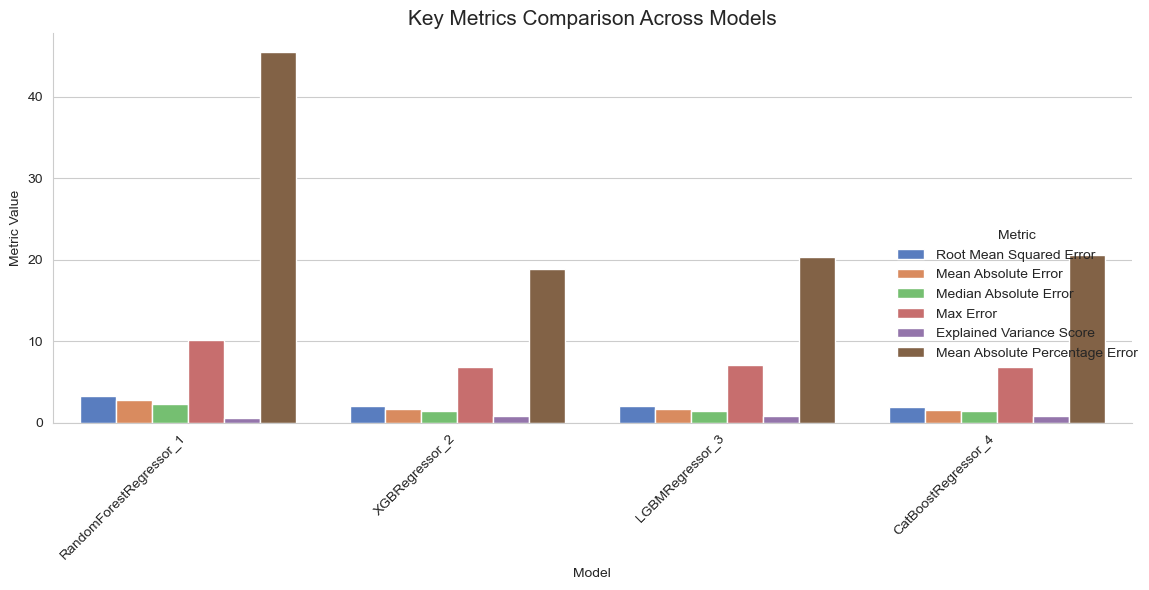

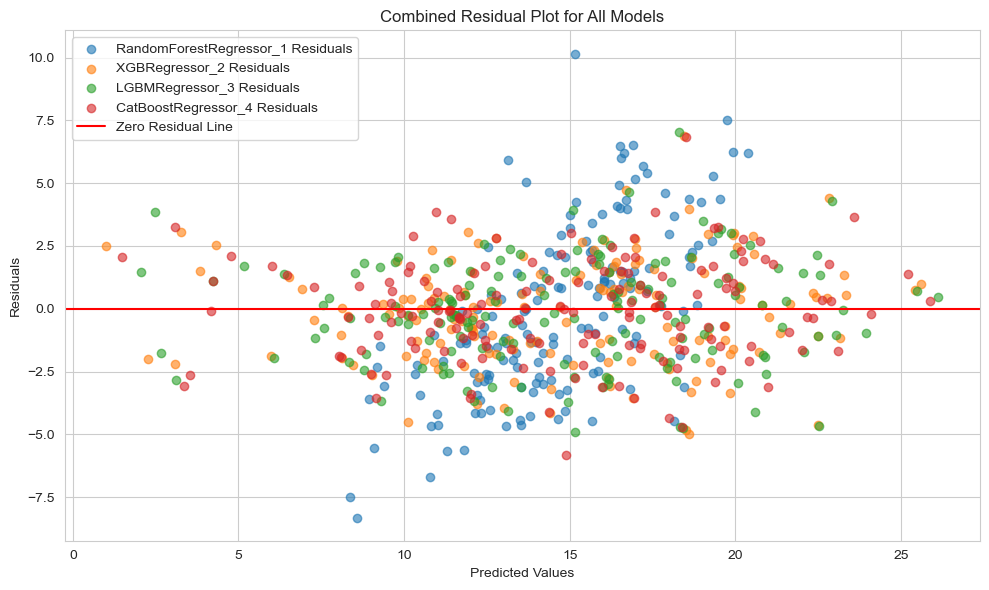

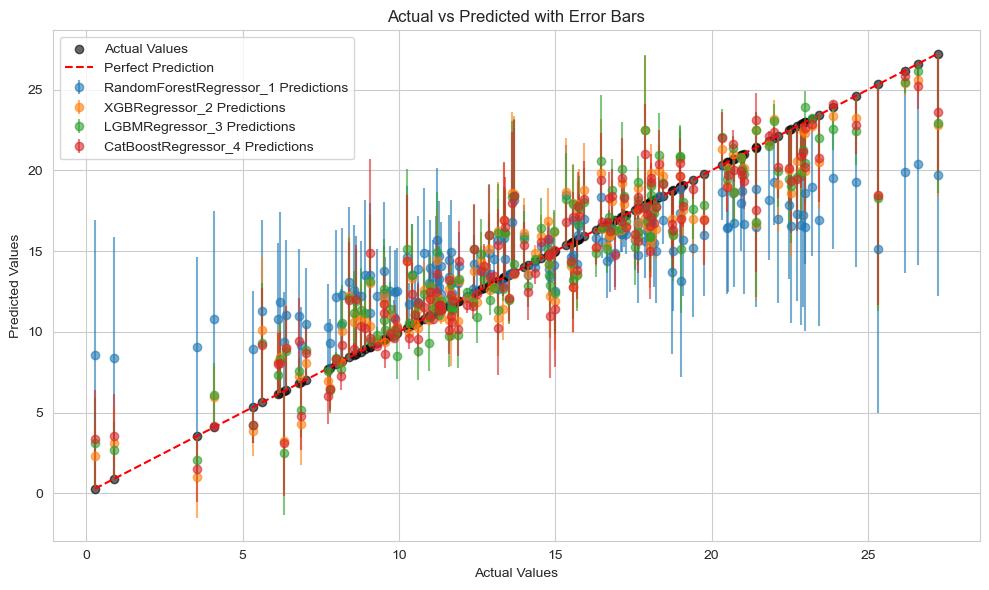

In [350]:
regression_report, comparison_df = evaluate_regression_models(
    [bayes_rf, bayes_xgb, bayes_lgbm, bayes_cat],  # , bayes_xgb, bayes_lgbm, bayes_cat
    x_test_scaled, 
    y_test, 
    output_dir="data/gold/evaluation_metrics"
)

In [351]:
comparison_df 

Mean Squared Error Root Mean Squared Error  \
RandomForestRegressor_1          11.114486                3.333839   
XGBRegressor_2                    4.156438                2.038735   
LGBMRegressor_3                   4.298411                2.073261   
CatBoostRegressor_4               3.817346                1.953803   

                        Mean Absolute Error Median Absolute Error  Max Error  \
RandomForestRegressor_1            2.734291              2.338336  10.164678   
XGBRegressor_2                     1.634115              1.376972   6.884021   
LGBMRegressor_3                    1.658891              1.467374   7.028516   
CatBoostRegressor_4                1.542202              1.381737   6.822188   

                        Explained Variance Score  \
RandomForestRegressor_1                 0.614054   
XGBRegressor_2                          0.856061   
LGBMRegressor_3                         0.851433   
CatBoostRegressor_4                     0.867654   

                        Mean Absolute Percentage Error  
RandomForestRegressor_1                      45.499776  
XGBRegressor_2                               18.814417  
LGBMRegressor_3                              20.380737  
CatBoostRegressor_4                           20.60207

### Optuna Evaluation

In [352]:
def evaluate_regression_models_optuna(models, X_test, y_test, output_dir="data/gold/evaluation_metrics"):
    """
    Evaluate multiple trained sklearn regression models and compare their performance.
    
    Parameters:
    -----------
    models : list
        List of trained sklearn model objects.
    X_test : pandas.DataFrame or numpy.ndarray
        Test features to evaluate the models.
    y_test : pandas.DataFrame or numpy.ndarray
        Test target values.
    output_dir : str, default="data/gold/evaluation_metrics"
        Directory where evaluation metrics and visualizations will be saved.
        
    Returns:
    --------
    tuple: (regression_report, comparison_df)
        regression_report: Dictionary containing detailed metrics for each model
        comparison_df: Pandas DataFrame with models as rows and metrics as columns
    """
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Flatten y_test if it's a DataFrame with a single column
    if hasattr(y_test, 'values'):
        y_test_values = y_test.values
    else:
        y_test_values = y_test
    
    if y_test_values.ndim > 1 and y_test_values.shape[1] == 1:
        y_test_values = y_test_values.flatten()
    
    # Define metrics for evaluation
    metrics = {
        'Mean Squared Error': mean_squared_error,
        'Root Mean Squared Error': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        'Mean Absolute Error': mean_absolute_error,
        'Median Absolute Error': median_absolute_error,
        'Max Error': max_error,
        'Explained Variance Score': explained_variance_score,
        'R² Score': r2_score,
        'Mean Absolute Percentage Error': lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100
    }
    
    # Initialize results container
    regression_report = {}
    all_predictions = {}
    comparison_data = {}
    
    # Evaluate each model
    for idx, model in enumerate(models):
        # Extract model name
        model_name = type(model).__name__
        if hasattr(model, 'custom_name'):
            model_name = model.custom_name
        else:
            model_name = f"{model_name}_{idx+1}"
        
        # Make predictions
        y_pred = model.predict(X_test)
        all_predictions[model_name] = y_pred
        
        # Calculate metrics
        model_metrics = {}
        for metric_name, metric_func in metrics.items():
            try:
                score = metric_func(y_test_values, y_pred)
                model_metrics[metric_name] = score
            except Exception as e:
                print(f"Error calculating {metric_name} for {model_name}: {e}")
                model_metrics[metric_name] = None
        
        # Add to regression report
        regression_report[model_name] = model_metrics
        
        # Add metrics to comparison data
        comparison_data[model_name] = model_metrics
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data).T  # Transpose to have models as rows and metrics as columns
    
    # Save comparison DataFrame
    comparison_df.to_csv(os.path.join(output_dir, 'model_comparison_metrics.csv'))
    
    # Create pivot table for easier visualization
    pivot_df = comparison_df.reset_index().rename(columns={'index': 'Model'})
    pivot_df.to_csv(os.path.join(output_dir, 'model_comparison_pivot.csv'), index=False)
    
    # Visualize comparison - bar chart
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Plot only the most important metrics
    important_metrics = ['Root Mean Squared Error', 'Mean Absolute Error', 'Median Absolute Error', 'Max Error', 'Explained Variance Score', 'Mean Absolute Percentage Error']
    plot_data = comparison_df[important_metrics].reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
    
    g = sns.catplot(
        data=plot_data,
        kind="bar",
        x="index",
        y="Value",
        hue="Metric",
        height=6,
        aspect=1.5,
        palette="muted",
    )
    
    plt.title("Key Metrics Comparison Across Models", fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Model')
    plt.ylabel('Metric Value')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'key_metrics_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot predicted vs actual for each model
    if hasattr(y_test, 'values'):
        actual_values = y_test.values
    else:
        actual_values = y_test
    
    if actual_values.ndim > 1 and actual_values.shape[1] == 1:
        actual_values = actual_values.flatten()
    
    # Create a combined residual plot for all models
    plt.figure(figsize=(10, 6))
    for model_name, y_pred in all_predictions.items():
        residuals = actual_values - y_pred
        plt.scatter(y_pred, residuals, alpha=0.6, label=f'{model_name} Residuals')
    
    plt.axhline(y=0, color='r', linestyle='-', label='Zero Residual Line')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Combined Residual Plot for All Models')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'combined_residual_plot.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create actual vs predicted plot with error bars for all models
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, actual_values, alpha=0.6, color='black', label='Actual Values')
    
    for model_name, y_pred in all_predictions.items():
        residuals = actual_values - y_pred
        plt.errorbar(actual_values, y_pred, yerr=np.abs(residuals), fmt='o', alpha=0.6, label=f'{model_name} Predictions')
    
    # Add perfect prediction line
    max_val = max(np.max(actual_values), np.max([np.max(pred) for pred in all_predictions.values()]))
    min_val = min(np.min(actual_values), np.min([np.min(pred) for pred in all_predictions.values()]))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted with Error Bars')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'actual_vs_predicted_with_error_bars.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save regression report
    joblib.dump(regression_report, os.path.join(output_dir, 'regression_report.pkl'))
    
    # Close all plots
    plt.close('all')
    
    return regression_report, comparison_df

<Figure size 1200x800 with 0 Axes>

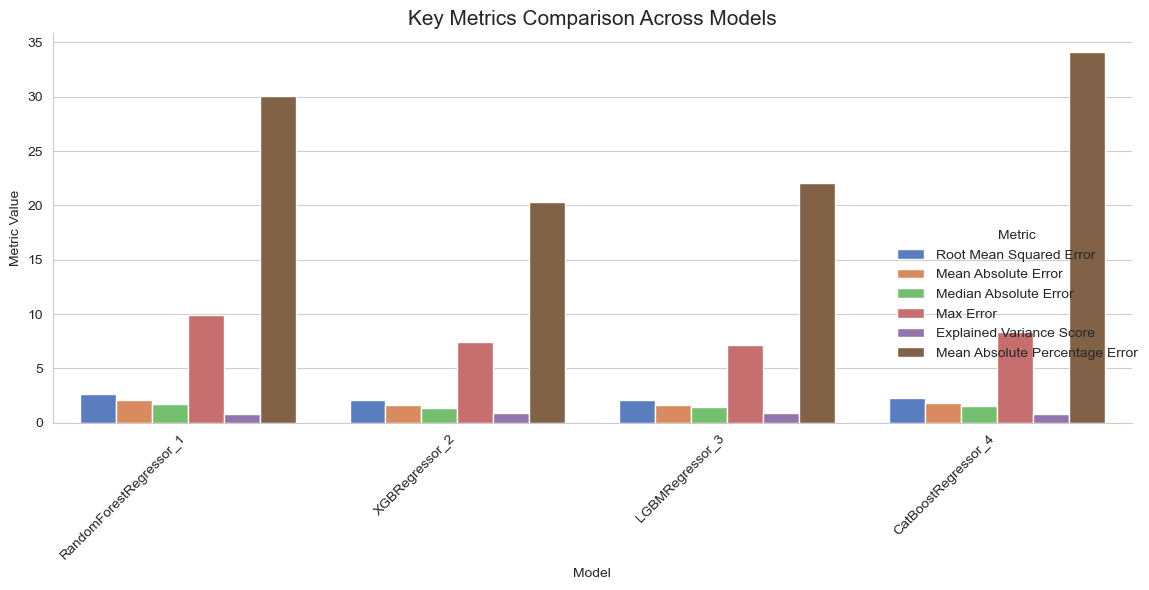

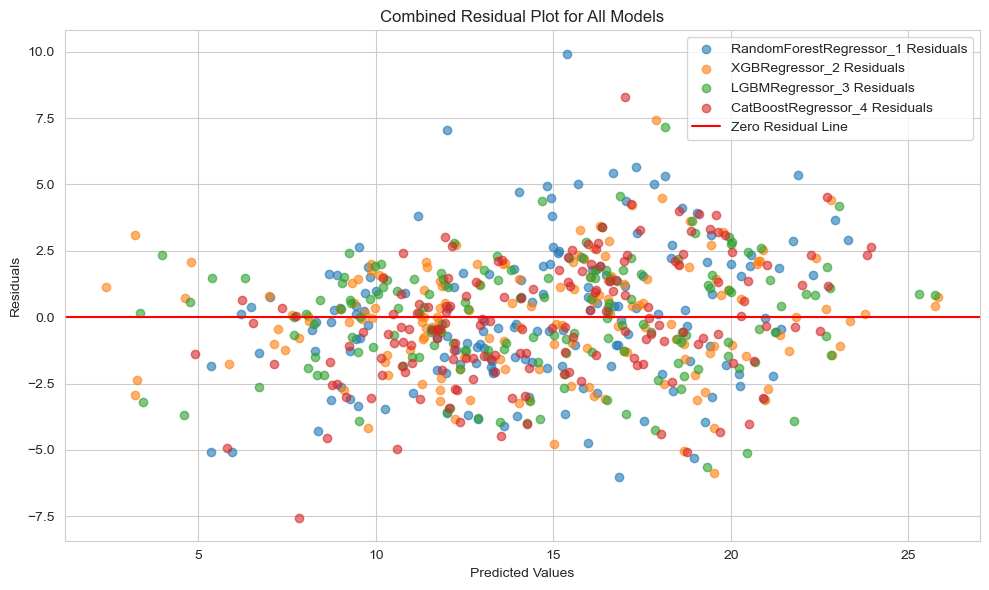

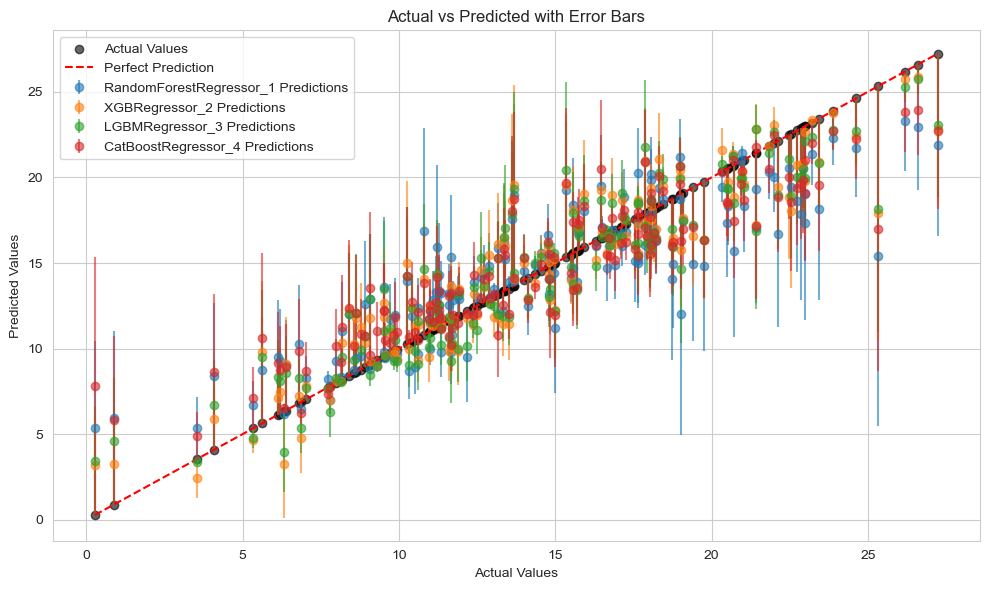

In [353]:
regression_report, comparison_df = evaluate_regression_models_optuna([rf_model, xgb_model, lgbm_model, cat_model], x_test_scaled, y_test, output_dir="data/gold/evaluation_metrics")

In [354]:
comparison_df

Mean Squared Error  Root Mean Squared Error  \
RandomForestRegressor_1            7.009570                 2.647559   
XGBRegressor_2                     4.212583                 2.052458   
LGBMRegressor_3                    4.266214                 2.065482   
CatBoostRegressor_4                5.275684                 2.296886   

                         Mean Absolute Error  Median Absolute Error  \
RandomForestRegressor_1             2.080068               1.746829   
XGBRegressor_2                      1.606542               1.354947   
LGBMRegressor_3                     1.660081               1.406743   
CatBoostRegressor_4                 1.817413               1.538904   

                         Max Error  Explained Variance Score  R² Score  \
RandomForestRegressor_1   9.932398                  0.756614  0.756487   
XGBRegressor_2            7.427131                  0.853700  0.853655   
LGBMRegressor_3           7.172347                  0.851795  0.851791   
CatBoostRegressor_4       8.310601                  0.817818  0.816722   

                         Mean Absolute Percentage Error  
RandomForestRegressor_1                       30.059202  
XGBRegressor_2                                20.293041  
LGBMRegressor_3                               22.083232  
CatBoostRegressor_4                           34.122640

## Model Evaluation

### Model Performance

### Model Interpretation

#### SHAP

In [339]:
def calculate_and_visualize_shap(model, X_test, output_dir="data/gold/final_model/shap"):
    """
    Calculate SHAP values for a tree-based model and visualize key SHAP plots.

    Parameters:
    -----------
    model: sklearn trained model
        A trained tree-based model (e.g., RandomForest, XGBoost, LightGBM, CatBoost).
    X_test: pandas.DataFrame or numpy.ndarray
        Test features to calculate SHAP values.
    output_dir: str, default="data/gold/final_model/shap"
        Directory to save SHAP plots.

    Returns:
    --------
    shap_values: numpy.ndarray
        SHAP values for the test dataset.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test)

    # Visualize and save SHAP summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title("SHAP Summary Plot")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "shap_summary_plot.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # Visualize and save SHAP decision plot
    plt.figure(figsize=(10, 8))
    shap.decision_plot(explainer.expected_value, shap_values, X_test, show=False)
    plt.title("SHAP Decision Plot")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "shap_decision_plot.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # Visualize and save SHAP dependence plots for all features
    for feature_idx in range(X_test.shape[1]):
        feature_name = X_test.columns[feature_idx] if hasattr(X_test, 'columns') else f"Feature_{feature_idx}"
        plt.figure(figsize=(10, 8))
        shap.dependence_plot(feature_idx, shap_values, X_test, show=False)
        plt.title(f"SHAP Dependence Plot for {feature_name}")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"shap_dependence_plot_{feature_name}.png"), dpi=300, bbox_inches='tight')
        plt.close()

    # Save SHAP values to a file
    shap_values_path = os.path.join(output_dir, "shap_values.npy")
    np.save(shap_values_path, shap_values)
    print(f"SHAP values saved to {shap_values_path}")

    return shap_values

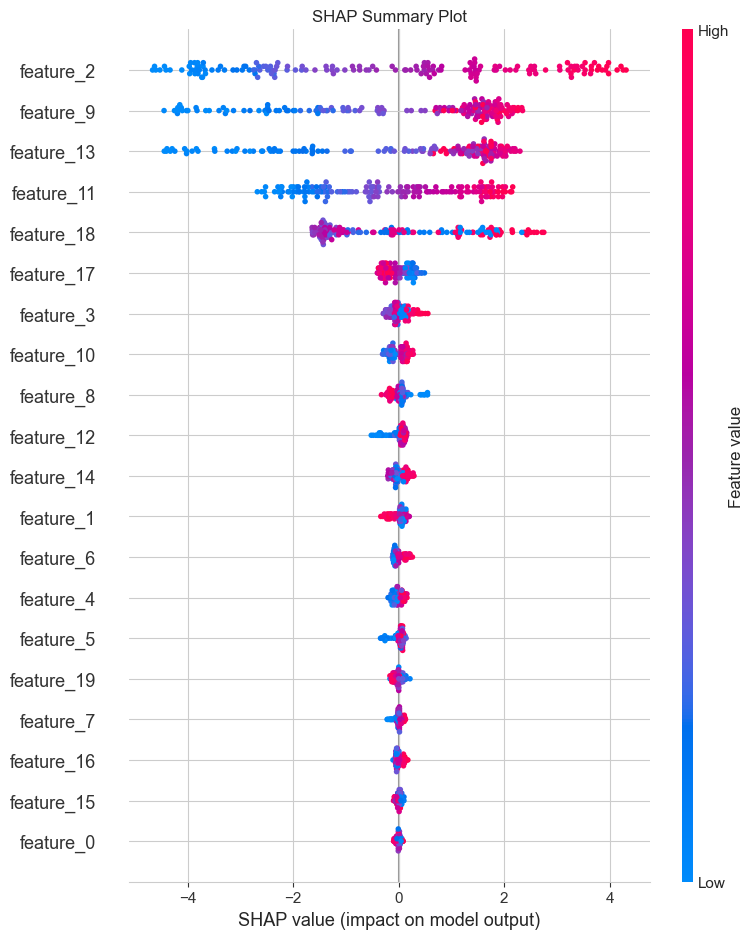

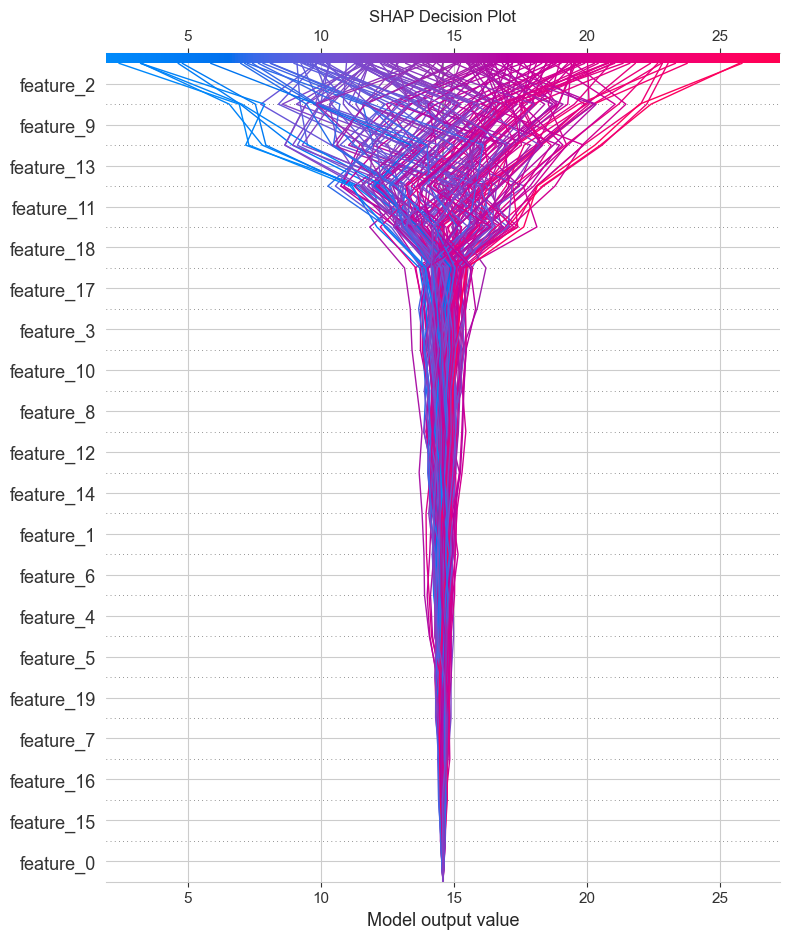

c:\Users\dfoso\anaconda3\envs\dev\Lib\site-packages\shap\plots\_scatter.py:579: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = pl.figure(figsize=figsize)


SHAP values saved to data/gold/final_model/shap\shap_values.npy


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [340]:
shap_values = calculate_and_visualize_shap(xgb_model, x_test_scaled, output_dir="data/gold/final_model/shap")

#### Feature Importance

In [ ]:
def visualize_feature_importance(model, X_test, output_dir="data/gold/final_model/feature_importance"):
    """
    Visualize feature importance for a tree-based model and save the plots.

    Parameters:
    -----------
    model: sklearn trained model
        A trained tree-based model (e.g., RandomForest, XGBoost, LightGBM, CatBoost).
    X_test: pandas.DataFrame or numpy.ndarray
        Test features to calculate feature importance.
    output_dir: str, default="data/gold/final_model/feature_importance"
        Directory to save feature importance plots.

    Returns:
    --------
    feature_importance_df: pandas.DataFrame
        DataFrame containing feature importance data.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get feature importance from the model
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    else:
        raise ValueError("The model does not have a 'feature_importances_' attribute.")

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        "Feature": X_test.columns if hasattr(X_test, 'columns') else [f"Feature_{i}" for i in range(X_test.shape[1])],
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Save feature importance DataFrame to a CSV file
    feature_importance_df.to_csv(os.path.join(output_dir, "feature_importance.csv"), index=False)
    print(f"Feature importance data saved to {os.path.join(output_dir, 'feature_importance.csv')}")

    # Visualize feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "feature_importance_plot.png"), dpi=300, bbox_inches='tight')
    plt.show()

    return feature_importance_df

Feature importance data saved to data/gold/final_model/feature_importance\feature_importance.csv


C:\Users\dfoso\AppData\Local\Temp\ipykernel_25008\2239416568.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")


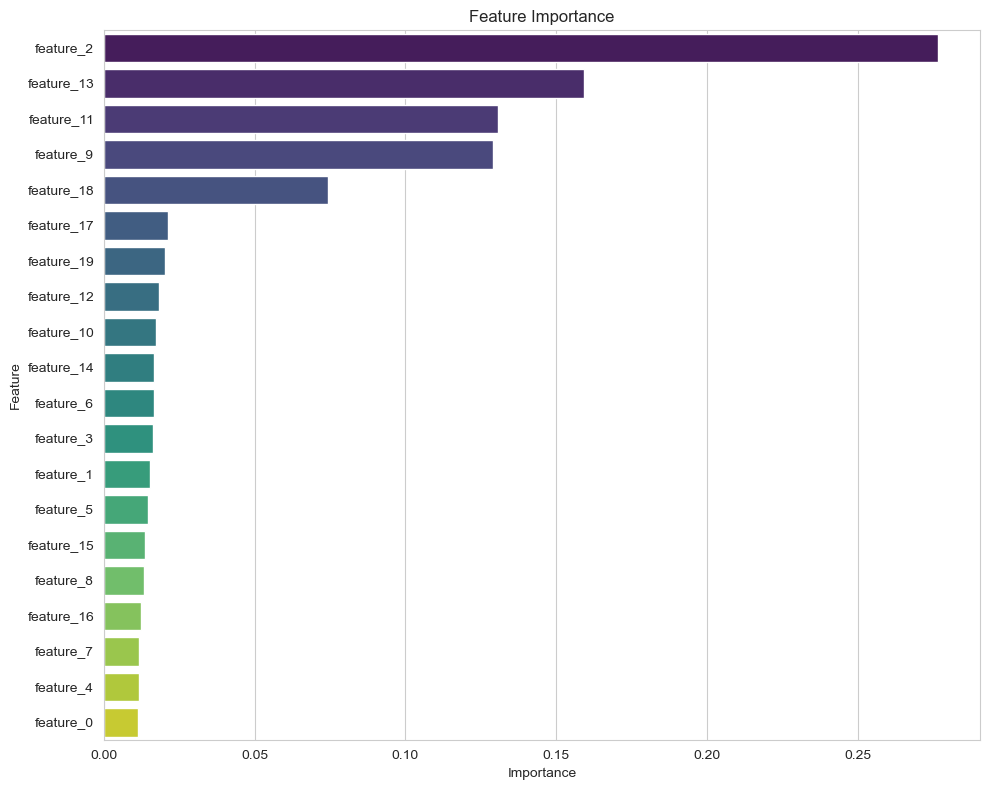

In [335]:
feature_importance_df = visualize_feature_importance(xgb_model, x_test_scaled)

In [341]:
feature_importance_df

Feature  Importance
2    feature_2    0.276801
13  feature_13    0.159315
11  feature_11    0.130751
9    feature_9    0.128946
18  feature_18    0.074353
17  feature_17    0.021350
19  feature_19    0.020322
12  feature_12    0.018179
10  feature_10    0.017106
14  feature_14    0.016641
6    feature_6    0.016490
3    feature_3    0.016194
1    feature_1    0.015234
5    feature_5    0.014722
15  feature_15    0.013481
8    feature_8    0.013395
16  feature_16    0.012396
7    feature_7    0.011691
4    feature_4    0.011488
0    feature_0    0.011145

## Predictions

In [343]:
# load tabular data from csv file
data_test = pd.read_csv('data/blind_test_data.csv')

# Define the directory path
directory = 'data/bronze'

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the file
data.to_csv(f'{directory}/data_test_bronze.csv', index=False)

data_test

feature_0   feature_1   feature_2   feature_3   feature_4   feature_5  \
0    676.867615   32.518822  254.825875  502.268510  609.469688  497.624266   
1    628.695228  426.163933  347.070280  431.106903  915.527507  301.699534   
2    131.765943  323.839669  245.399775  181.814398  710.179159   59.117377   
3    160.970195  489.712029   70.482159  309.486269  888.030604  412.655666   
4    419.907137  216.625219  487.887860  253.704462  323.226862   65.744463   
..          ...         ...         ...         ...         ...         ...   
195  338.704937  571.484945   81.944368  184.017130  832.342389  266.000377   
196  636.334900  463.410003  108.586165   69.428378  647.404723   29.340233   
197  435.715962  224.963040  438.132233  388.507029   18.294208  124.111105   
198  838.424816  158.607679  413.606784  291.848099  455.663252   60.007796   
199  685.181970  558.752726  176.051484  547.903895  500.995452  501.100060   

      feature_6   feature_7   feature_8   feature_9  feature_10  feature_11  \
0    105.246239  269.045539  150.177005  312.649860  765.296227    0.237996   
1      1.666992  306.733041  104.234252   63.242070  467.009734    6.608084   
2    312.622788  687.965027  109.803179  381.169500  700.532108    1.822370   
3    216.124989   47.415477  104.139145  326.462385  378.446187    1.686895   
4    271.811469  527.726782  129.805782  168.429679  637.944633    0.948507   
..          ...         ...         ...         ...         ...         ...   
195  257.142157  754.889691  255.502127  109.691700  556.704439    5.948526   
196   91.548173   73.493978  192.087685  373.060558  648.906863    1.021152   
197  198.481796  401.100473  148.652952  360.232978  567.386243    1.438832   
198  361.420138   38.148173  330.397949  143.520905  103.086344    0.106124   
199  155.535149  615.040599  148.151929  336.529767  502.932903    5.850888   

     feature_12  feature_13  feature_14  feature_15  feature_16  feature_17  \
0    660.030637  147.059794   40.232132  464.424834  121.147466   68.284243   
1    600.994184   43.619815   48.153926  457.256565   49.163652   85.511662   
2    736.306092  138.759029   36.915389  436.174065   10.037994   62.631938   
3    485.144327  143.668518   27.168148  309.715497  149.661493   66.415878   
4    365.946758   72.337904   36.232169  302.772338  186.944884  106.514846   
..          ...         ...         ...         ...         ...         ...   
195  728.419142  174.741510   27.102480  128.738736  179.130863   91.028342   
196  432.620953   90.630144   42.741525  375.416247  160.475640   76.325002   
197  916.375260    5.515257   39.389621  546.273628   20.791345  132.257432   
198  650.671949   85.071368   39.471232  115.479997   32.710473  137.775278   
199   65.325331  102.519883   37.927566  474.402615   25.119786   77.036973   

     feature_18  feature_19  
0     26.969870  314.461582  
1     33.500538  819.537877  
2      6.211169  341.361374  
3     15.001753  539.087409  
4      3.443809  364.341969  
..          ...         ...  
195   19.159594  881.204989  
196   27.156436  470.161969  
197   20.496401  668.933127  
198   50.045511  487.376756  
199   20.758504  383.794949  

[200 rows x 20 columns]

In [346]:
def generate_predictions(data_test, scaler_dir="data/gold/scaler", best_model=None, output_dir="data/gold/final_model"):
    """
    Generate predictions using a trained model and a pre-trained scaler.

    Parameters:
    -----------
    data_test: pandas.DataFrame
        DataFrame with features to generate predictions.
    scaler_dir: str, default="data/gold/scaler"
        Directory containing the saved scaler (standard_scaler.pkl).
    best_model: sklearn trained model
        A trained model to generate predictions.
    output_dir: str, default="data/gold/final_model"
        Directory to save the predictions.

    Returns:
    --------
    predictions_df: pandas.DataFrame
        DataFrame containing the predictions.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Load the pre-trained scaler
    scaler_path = os.path.join(scaler_dir, "standard_scaler.pkl")
    if not os.path.exists(scaler_path):
        raise FileNotFoundError(f"Scaler not found at {scaler_path}")
    
    scaler = joblib.load(scaler_path)

    # Transform the test data using the scaler
    data_test_scaled = scaler.transform(data_test)

    # Generate predictions using the trained model
    if best_model is None:
        raise ValueError("No trained model provided.")
    
    predictions = best_model.predict(data_test_scaled)

    # Create a DataFrame for the predictions
    predictions_df = pd.DataFrame(predictions, columns=["target_pred"])

    # Save predictions to a CSV file
    predictions_path = os.path.join(output_dir, "predictions.csv")
    predictions_df.to_csv(predictions_path, index=False)
    print(f"Predictions saved to {predictions_path}")

    return predictions_df

In [347]:
predictions_df = generate_predictions(data_test, scaler_dir="data/gold/scaler", best_model=xgb_model)

Predictions saved to data/gold/final_model\predictions.csv


In [362]:
predictions_df

target_pred
0      12.977493
1      12.286625
2      15.759097
3      11.889402
4      17.285013
..           ...
195    11.839395
196    10.667293
197    10.353033
198    15.150010
199    16.512121

[200 rows x 1 columns]

## Model Deployment